<a href="https://colab.research.google.com/github/kimdonggyu2008/deep_daiv_-/blob/main/Avocodo_Pipeline_wavlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 원본 코드

https://github.com/ncsoft/avocodo

# Avocodo 사전 설정


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install wandb

In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install OmegaConf

In [ ]:
!pip install torchinfo

In [ ]:
# 공통으로 사용되는 라이브러리
import os
import glob
import json
import math
import time
import random
import argparse
import warnings
import itertools
from itertools import chain
from scipy import signal as sig
from scipy.signal.windows import kaiser
from omegaconf import OmegaConf
import sys



# 데이터 처리 관련 라이브러리
import numpy as np
from scipy.io.wavfile import read, write
from scipy import signal as sig
import librosa
from librosa.filters import mel as librosa_mel_fn
from librosa.util import normalize
from dataclasses import dataclass
from typing import List
from pytorch_lightning import LightningDataModule
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.loggers import TensorBoardLogger


# PyTorch 및 TensorBoard 관련 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
from torch.distributed import init_process_group
from torch.nn.parallel import DistributedDataParallel
torch.backends.cudnn.benchmark = True

# 시각화 및 플롯 관련 라이브러리
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt

# 유틸리티 관련 모듈
import shutil


In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = "513a1f0c050fa7f60a76b5232e904d8df397082e"
wandb.login()

#meldataset.py

In [ ]:

MAX_WAV_VALUE = 32768.0


def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate


def dynamic_range_compression(x, C=1, clip_val=1e-5): #튀는 부분 처리
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1): #작은 부분 키우기
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5): #토치버전 튀는 부분 처리
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression_torch(x, C=1): #토치버전 작은 부분 키우기
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes): #토치 버전 스펙트로그램 정규화
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes): #토치버전 스펙트로그램 비정규화
    output = dynamic_range_decompression_torch(magnitudes)
    return output


In [ ]:
mel_basis = {}
hann_window = {}

In [ ]:
def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.: #정규화 여부
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=True)
    spec = torch.view_as_real(spec)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec


In [ ]:
def get_dataset_filelist(
    input_wavs_dir,
    input_training_file,
    input_validation_file
):
    with open(input_training_file, 'r', encoding='utf-8') as fi:
        training_files = [os.path.join(input_wavs_dir, x.split('|')[0] + '.wav')
                          for x in fi.read().split('\n') if len(x) > 0]

    with open(input_validation_file, 'r', encoding='utf-8') as fi:
        validation_files = [os.path.join(input_wavs_dir, x.split('|')[0] + '.wav')
                            for x in fi.read().split('\n') if len(x) > 0]
    return training_files, validation_files


In [ ]:
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, training_files, segment_size, n_fft, num_mels,
                 hop_size, win_size, sampling_rate,  fmin, fmax, split=True, shuffle=True, n_cache_reuse=1,
                 fmax_loss=None, fine_tuning=False, base_mels_path=None):
        self.audio_files = training_files
        random.seed(1234)
        if shuffle:
            random.shuffle(self.audio_files)
        self.segment_size = segment_size #1개의 샘플 내에서 묶을 신호의 갯수
        self.sampling_rate = sampling_rate
        self.split = split #segment_size로 자를지에 대한 여부
        self.n_fft = n_fft #fft에서 나눌 주파수 대역의 갯수
        self.num_mels = num_mels #멜 필터 사용 갯수
        self.hop_size = hop_size #나눠진 각 구간에 대한
        self.win_size = win_size #stft에서 분석할 샘플 갯수
        self.fmin = fmin #사용할 최소 주파수
        self.fmax = fmax #사용할 최대 주파수
        self.fmax_loss = fmax_loss #멜 손실 최댓값
        self.cached_wav = None
        self.n_cache_reuse = n_cache_reuse
        self._cache_ref_count = 0
        self.fine_tuning = fine_tuning #파인튜닝 여부
        self.base_mels_path = base_mels_path# 저장된 멜 스펙트로그램 데이터경로

    def __getitem__(self, index): #오디오 파일들 가져옴
        filename = self.audio_files[index]
        if self._cache_ref_count == 0:
            audio, sampling_rate = load_wav(filename) #[num_samples]
            audio = audio / MAX_WAV_VALUE
            if not self.fine_tuning: #파인 튜닝 여부에 따라 정규화, 첫 학습인 경우 npy
                audio = normalize(audio) * 0.95 #[num_samples]
            self.cached_wav = audio
            if sampling_rate != self.sampling_rate: #샘플레이트 맞추기
                raise ValueError("{} SR doesn't match target {} SR".format(
                    sampling_rate, self.sampling_rate))
            self._cache_ref_count = self.n_cache_reuse
        else:
            audio = self.cached_wav
            self._cache_ref_count -= 1

        audio = torch.FloatTensor(audio)#텐서화
        audio = audio.unsqueeze(0)#[1, num_samples]

        if not self.fine_tuning:
            if self.split:
                if audio.size(1) >= self.segment_size: #샘플 길이가 세그먼트 갯수보다 긴 경우
                    max_audio_start = audio.size(1) - self.segment_size
                    audio_start = random.randint(0, max_audio_start)
                    audio = audio[:, audio_start:audio_start+self.segment_size]
                    #랜덤 시작위치에서 세그먼트 길이까지 자름,[1,segment_size]
                else:
                    audio = torch.nn.functional.pad(audio, (0, self.segment_size - audio.size(1)), 'constant')
                    #짧으면 오디오에 제로 패딩 추가
            mel = mel_spectrogram(audio, self.n_fft, self.num_mels,
                                  self.sampling_rate, self.hop_size, self.win_size, self.fmin, self.fmax,
                                  center=False)
            #num_mels랑 hop_size, win_size로 멜로 만듦, [num_mels, num_frames]
        else:

            mel = np.load(
                os.path.join(self.base_mels_path, os.path.splitext(os.path.split(filename)[-1])[0] + '.npy'))
            mel = torch.from_numpy(mel)
                # [num_mels, num_frames]
            if len(mel.shape) < 3: #3개 값 안가지면, 차원 증강
                mel = mel.unsqueeze(0)
                # [1, num_mels,num_frames]

            if self.split:
                frames_per_seg = math.ceil(self.segment_size / self.hop_size) #프레임 갯수 계산
                # [1, num_mels, num_frames]
                if audio.size(1) >= self.segment_size:
                    mel_start = random.randint(0, mel.size(2) - frames_per_seg - 1)
                    mel = mel[:, :, mel_start:mel_start + frames_per_seg] #[ 1,num_mels,frames_per_seg]
                    audio = audio[:, mel_start * self.hop_size:(mel_start + frames_per_seg) * self.hop_size]
                    # [1,segment_size]
                else:
                    mel = torch.nn.functional.pad(mel, (0, frames_per_seg - mel.size(2)), 'constant') #[1,num_mels,num_frames]
                    audio = torch.nn.functional.pad(audio, (0, self.segment_size - audio.size(1)), 'constant')
                    # [1,num_mels, frames_per_seg]
        mel_loss = mel_spectrogram(audio, self.n_fft, self.num_mels,
                                   self.sampling_rate, self.hop_size, self.win_size, self.fmin, self.fmax_loss,
                                   center=False)
        # [1, segment_size] -> [num_mels, frames_per_seg]
        return (mel.squeeze(), audio.squeeze(0), filename, mel_loss.squeeze())

    def __len__(self):
        return len(self.audio_files)

In [ ]:
# import os
# import numpy as np
# import torch

# # MelDataset 클래스에서 멜 스펙트로그램 생성 함수 필요
# def generate_mel_and_save(audio_files, segment_size, n_fft, num_mels, hop_size, win_size,
#                           sampling_rate, fmin, fmax, output_dir):
#     for index, file_path in enumerate(audio_files):
#         try:
#             # 1. Load wav file
#             audio, sampling_rate_loaded = load_wav(file_path)
#             audio = audio / MAX_WAV_VALUE
#             audio = normalize(audio) * 0.95  # Normalize audio

#             # 2. Ensure correct sampling rate
#             if sampling_rate != sampling_rate_loaded:
#                 raise ValueError(f"File {file_path} has mismatched sampling rate {sampling_rate_loaded}.")

#             # 3. Convert to PyTorch Tensor and add batch dimension
#             audio = torch.FloatTensor(audio).unsqueeze(0)  # Shape: [1, num_samples]

#             # 4. Segment audio if it's longer than the segment size
#             if audio.size(1) > segment_size:
#                 max_audio_start = audio.size(1) - segment_size
#                 audio_start = random.randint(0, max_audio_start)
#                 audio = audio[:, audio_start:audio_start + segment_size]
#             else:
#                 # Pad if shorter than segment size
#                 audio = torch.nn.functional.pad(audio, (0, segment_size - audio.size(1)), 'constant')

#             # 5. Generate mel spectrogram
#             mel = mel_spectrogram(audio, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False)

#             # 6. Save mel spectrogram as .npy
#             file_name = os.path.splitext(os.path.basename(file_path))[0]  # Get file name without extension
#             npy_path = os.path.join(output_dir, f"{file_name}.npy")
#             np.save(npy_path, mel.numpy())  # Save mel spectrogram as numpy file

#             print(f"Processed and saved: {npy_path}")

#         except Exception as e:
#             print(f"Error processing file {file_path}: {e}")


# # Example usage with configuration
# data_config = {
#     "segment_size": 8192,
#     "num_mels": 80,
#     "n_fft": 1024,
#     "hop_size": 256,
#     "win_size": 1024,
#     "sampling_rate": 22050,
#     "fmin": 0,
#     "fmax": 8000
# }

# # File paths
# input_wavs_dir = '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs'
# output_mels_dir = '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/mel_spectrogram'

# # Gather all wav files
# wav_files = [os.path.join(input_wavs_dir, f) for f in os.listdir(input_wavs_dir) if f.endswith('.wav')]

# # Ensure output directory exists
# os.makedirs(output_mels_dir, exist_ok=True)

# # Generate and save mel spectrograms
# generate_mel_and_save(
#     audio_files=wav_files,
#     segment_size=data_config["segment_size"],
#     n_fft=data_config["n_fft"],
#     num_mels=data_config["num_mels"],
#     hop_size=data_config["hop_size"],
#     win_size=data_config["win_size"],
#     sampling_rate=data_config["sampling_rate"],
#     fmin=data_config["fmin"],
#     fmax=data_config["fmax"],
#     output_dir=output_mels_dir
# )


# utils.py


In [ ]:
def get_padding(kernel_size, dilation=1): #제로 패딩 추가
    return int((kernel_size*dilation - dilation)/2)


def init_weights(m, mean=0.0, std=0.01): #가중치 초기화
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)

# losses.py


GAN 로스

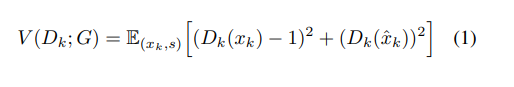

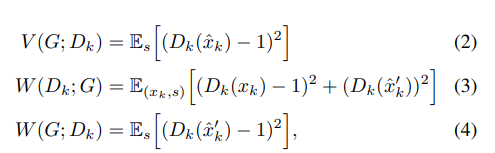

FEATURE MATCHING 로스

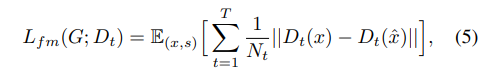

In [ ]:
# Feature Matching Loss
def feature_loss(fmap_r, fmap_g):
    loss = 0
    losses = []
    for dr, dg in zip(fmap_r, fmap_g): #각각에 대해 절댓값으로 비교
        for rl, gl in zip(dr, dg):
            _loss = torch.mean(torch.abs(rl - gl)) #절댓값 평균으로 비교
            loss += _loss
        losses.append(_loss)

    return loss*2, losses

def discriminator_loss(disc_real_outputs, disc_generated_outputs):# 분류자 로스
    loss = 0
    r_losses = []
    g_losses = []
    for dr, dg in zip(disc_real_outputs, disc_generated_outputs): #실제 값과 생성된 값을 각각 비교
        r_loss = torch.mean((1-dr)**2)
        g_loss = torch.mean(dg**2)
        loss += (r_loss + g_loss)
        r_losses.append(r_loss.item())# 각 데이터들의 로스를 추가함
        g_losses.append(g_loss.item())

    return loss, r_losses, g_losses


def generator_loss(disc_outputs): #생성자 로스값
    loss = 0
    gen_losses = []
    for dg in disc_outputs:
        l = torch.mean((1-dg)**2)
        gen_losses.append(l)
        loss += l

    return loss, gen_losses

# pqmf.py

SINC 함수

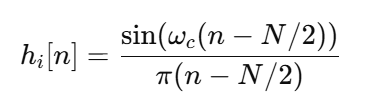

In [ ]:
def design_prototype_filter(taps=62, cutoff_ratio=0.142, beta=9.0): #프로토타입 필터 예시
    """Design prototype filter for PQMF.
    This method is based on `A Kaiser window approach for the design of prototype
    filters of cosine modulated filterbanks`_.
    Args:
        taps (int): The number of filter taps.
        cutoff_ratio (float): Cut-off frequency ratio.
        beta (float): Beta coefficient for kaiser window.
    Returns:
        ndarray: Impluse response of prototype filter (taps + 1,).
    .. _`A Kaiser window approach for the design of prototype filters of cosine modulated filterbanks`:
        https://ieeexplore.ieee.org/abstract/document/681427
    """
    # check the arguments are valid, 제약조건
    assert taps % 2 == 0, "The number of taps mush be even number." #소수 지정
    assert 0.0 < cutoff_ratio < 1.0, "Cutoff ratio must be > 0.0 and < 1.0." #컷오프 비율

    # make initial filter
    omega_c = np.pi * cutoff_ratio #라디안 단위로 차단 주파수 계산
    with np.errstate(invalid="ignore"): #차단 주파수 기준으로 sinc함수로 필터 설계
        h_i = np.sin(omega_c * (np.arange(taps + 1) - 0.5 * taps)) / (
            np.pi * (np.arange(taps + 1) - 0.5 * taps)
        )
    h_i[taps // 2] = np.cos(0) * cutoff_ratio  # 완전 중심값의 경우, 분모가 0이므로 에러 발생하므로 예외처리

    # apply kaiser window, 양 끝의 스무딩 처리
    w = kaiser(taps + 1, beta)# 양 옆으로 있고, 중간에 1개만 있으므로 +1, 베타를 가지는 카이저 윈도우
    h = h_i * w # 초기 필터 값에 카이저 윈도우를 곱해서 최종 필터 생성

    return h

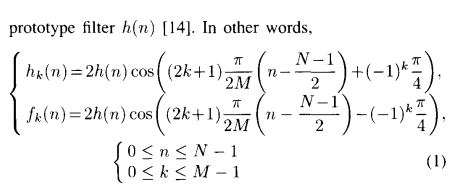

https://github.com/kan-bayashi/ParallelWaveGAN/blob/86740373ec609cb9fb192d472d2aea125041491a/parallel_wavegan/layers/pqmf.py#L51

In [ ]:
class PQMF(torch.nn.Module):
    """PQMF module.
    This module is based on `Near-perfect-reconstruction pseudo-QMF banks`_.
    .. _`Near-perfect-reconstruction pseudo-QMF banks`:
        https://ieeexplore.ieee.org/document/258122
    """

    def __init__(self, subbands=4, taps=62, cutoff_ratio=0.142, beta=9.0):
        """Initilize PQMF module.
        The cutoff_ratio and beta parameters are optimized for #subbands = 4.
        See dicussion in https://github.com/kan-bayashi/ParallelWaveGAN/issues/195.
        Args:
            subbands (int): The number of subbands.
            taps (int): The number of filter taps.
            cutoff_ratio (float): Cut-off frequency ratio.
            beta (float): Beta coefficient for kaiser window.
        """
        super(PQMF, self).__init__() #원본 PQMF를 기반으로 업그레이드

        # build analysis & synthesis filter coefficients, 분석 필터, 합성필터 설계
        h_proto = design_prototype_filter(taps, cutoff_ratio, beta) #필터 생성
        h_analysis = np.zeros((subbands, len(h_proto))) #서브 밴드 대역만큼 0으로 된 배열 생성
        h_synthesis = np.zeros((subbands, len(h_proto))) #합성도 동일한 크기의 배열 생성
        for k in range(subbands): #각 대역별로 분석, 합성을 진행
            h_analysis[k] = (
                2
                * h_proto
                * np.cos(
                    (2 * k + 1)
                    * (np.pi / (2 * subbands))
                    * (np.arange(taps + 1) - (taps / 2))
                    + (-1) ** k * np.pi / 4 #여기만 다름
                )
            )
            h_synthesis[k] = (
                2
                * h_proto
                * np.cos(
                    (2 * k + 1)
                    * (np.pi / (2 * subbands))
                    * (np.arange(taps + 1) - (taps / 2))
                    - (-1) ** k * np.pi / 4 #여기만 다름
                )
            )

        # convert to tensor
        analysis_filter = torch.from_numpy(h_analysis).float().unsqueeze(1) #텐서로 변경
        synthesis_filter = torch.from_numpy(h_synthesis).float().unsqueeze(0)

        # register coefficients as beffer
        self.register_buffer("analysis_filter", analysis_filter) #모델 버퍼로 등록해서, 학습중에 업데이트 안되게 서렂ㅇ
        self.register_buffer("synthesis_filter", synthesis_filter)

        # filter for downsampling & upsampling
        updown_filter = torch.zeros((subbands, subbands, subbands)).float() #필터생성
        for k in range(subbands):
            updown_filter[k, k, 0] = 1.0
        self.register_buffer("updown_filter", updown_filter)
        self.subbands = subbands

        # keep padding info
        self.pad_fn = torch.nn.ConstantPad1d(taps // 2, 0.0) #패딩 함수 설정, 신호 길이 유지

    def analysis(self, x): #다운 샘플링
        """Analysis with PQMF.
        Args:
            x (Tensor): Input tensor (B, 1, T).
        Returns:
            Tensor: Output tensor (B, subbands, T // subbands).
        """
        x = F.conv1d(self.pad_fn(x), self.analysis_filter) #패딩 추가, [batch_size, subbands, t]
        return F.conv1d(x, self.updown_filter, stride=self.subbands)#(batch_size, sub_bands,t//sub_bands)
        #self.subbands를 사용해 서브밴드 수만큼 나눠서 다운샘플링

    def synthesis(self, x): #업 샘플링
        """Synthesis with PQMF.
        Args:
            x (Tensor): Input tensor (B, subbands, T // subbands).
        Returns:
            Tensor: Output tensor (B, 1, T).
        """
        # NOTE(kan-bayashi): Power will be dreased so here multipy by # subbands.
        #   Not sure this is the correct way, it is better to check again.
        # TODO(kan-bayashi): Understand the reconstruction procedure
        x = F.conv_transpose1d( #업샘플링, 서브밴드 크기만큼 업샘플링
            x, self.updown_filter * self.subbands, stride=self.subbands
        )#[batch_size, subbands, t//subbands]
        return F.conv1d(self.pad_fn(x), self.synthesis_filter)#[batch_size, 1, t]

# CoMBD.py

In [ ]:
class CoMBDBlock(torch.nn.Module):
    def __init__( #CoMBD 블록 선언
        self,
        h_u: List[int], #각 계층별 출력 갯수(히든 유닛) 리스트
        d_k: List[int], #각 계층의 커널 크기 리스트
        d_s: List[int], #각 계층의 스트라이드 리스트
        d_d: List[int], #각 계층의 dilation(확장 계수) 리스트
        d_g: List[int], #각 계층의 그룹 수 리스트
        d_p: List[int], #각 계층의 패딩 크기 리스트
        op_f: int, #프로젝션 계층의 출력 채널 크기
        op_k: int, #프로젝션 계층의 커널 크기
        op_g: int, #프로젝션 계층의 그룹 수
        use_spectral_norm=False #spectral normalization 적용여부
    ):
        super(CoMBDBlock, self).__init__() #combd 내용 기반으로 업그레이드
        norm_f = weight_norm if use_spectral_norm is False else spectral_norm #스펙트럼 정규화, 가중치 정규화 선택

        self.convs = nn.ModuleList() #다층 컨볼루션 모델 생성
        filters = [[1, h_u[0]]] #출력 필터 지정
        for i in range(len(h_u) - 1): #각 계층마다 필터 지정
            filters.append([h_u[i], h_u[i + 1]]) #각 필터 시작지점, 끝지점으로 묶기
        for _f, _k, _s, _d, _g, _p in zip(filters, d_k, d_s, d_d, d_g, d_p):#각 대역폭별로 사용될 데이터 묶기
            self.convs.append(norm_f(
                Conv1d( #가중치들을 활용해 conv1d 계층 생성
                    in_channels=_f[0],
                    out_channels=_f[1],
                    kernel_size=_k,
                    stride=_s,
                    dilation=_d,
                    groups=_g,
                    padding=_p
                )
            ))
        self.projection_conv = norm_f( #제일 마지막 프로젝션 레이어
            Conv1d(
                in_channels=filters[-1][1],
                out_channels=op_f,
                kernel_size=op_k,
                groups=op_g
            )
        )

    def forward(self, x):
        fmap = []
        for block in self.convs:
            x = block(x) #블록
            x = F.leaky_relu(x, 0.2) #활성화 함수, 비선형성 추가
            fmap.append(x) #묶어서 추가, 각 계층의 출력에 대해 추가
        x = self.projection_conv(x) #최종 출력 변환
        return x, fmap    #CoMBD 블록 반환


In [ ]:
class CoMBD(torch.nn.Module): #내부 combd
    def __init__(self, h, pqmf_list=None, use_spectral_norm=False):
        super(CoMBD, self).__init__()
        self.h = h #하이퍼 파라미터 설정 객체, h는 combd, combd_block에 대한 구조 정의
        if pqmf_list is not None: #대역 분할 있으면, 지정
            self.pqmf = pqmf_list
        else: #대역 분할이 없으면 LV1, LV2로 분할
            self.pqmf = [
                PQMF(*h.pqmf_config["lv2"]),
                PQMF(*h.pqmf_config["lv1"])
            ]

        self.blocks = nn.ModuleList() #CoMBD 블럭의 데이터 가져옴
        for _h_u, _d_k, _d_s, _d_d, _d_g, _d_p, _op_f, _op_k, _op_g in zip(
            h.combd_h_u,
            h.combd_d_k,
            h.combd_d_s,
            h.combd_d_d,
            h.combd_d_g,
            h.combd_d_p,
            h.combd_op_f,
            h.combd_op_k,
            h.combd_op_g,
        ):
            self.blocks.append(CoMBDBlock( #COMBD 블럭들 쌓기
                _h_u,
                _d_k,
                _d_s,
                _d_d,
                _d_g,
                _d_p,
                _op_f,
                _op_k,
                _op_g,
            ))

    def _block_forward(self, input, blocks, outs, f_maps): #순차적 통과, 중간 표현 확인
        for x, block in zip(input, blocks):
            out, f_map = block(x) #각 계층마다의 중간맵 출력
            outs.append(out)
            f_maps.append(f_map)
        return outs, f_maps             # 계층마다 intermidiate feature map 출력할 수 있도록

    def _pqmf_forward(self, ys, ys_hat):
        # ys는 실제 신호 리스트 - training_step 파트에서 만들어짐
        # ys_hat은 생성된 신호 리스트
        #  ys = [
        #self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],  # PQMF Level 2
        #self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],  # PQMF Level 1
        #y  ] # 원래 입력 신호
        multi_scale_inputs = [] #PQMF를 통한 신호의 대역폭 분할, analysis 함수 이용
        multi_scale_inputs_hat = []
        for pqmf in self.pqmf: #lv1, lv2가 들어가있는 pqmf 객체 리스트에 다운샘플링, 대역별 분할
            multi_scale_inputs.append(  #analysis 함수는 일종의 다운샘플링
                pqmf.to(ys[-1]).analysis(ys[-1])[:, :1, :] #batch_size, subband,t
            )
            multi_scale_inputs_hat.append(
                pqmf.to(ys[-1]).analysis(ys_hat[-1])[:, :1, :]
            )

        outs_real = []
        f_maps_real = []
        # real
        # for hierarchical forward
        outs_real, f_maps_real = self._block_forward(
            ys, self.blocks, outs_real, f_maps_real)                # input : ys
        # for multi_scale forward
        outs_real, f_maps_real = self._block_forward(
            multi_scale_inputs, self.blocks[:-1], outs_real, f_maps_real)
        # outs_real: 실제 음성의 출력
	    # f_maps_real: 실제 음성의 중간 특징 맵


        outs_fake = [] #생성 신호 처리
        f_maps_fake = []
        # predicted
        # for hierarchical forward
        outs_fake, f_maps_fake = self._block_forward( #실제 신호, 생성 신호에 대한 중간 특징맵 파악
            ys_hat, self.blocks, outs_fake, f_maps_fake)     # input : ys_hat
        # for multi_scale forward
        outs_fake, f_maps_fake = self._block_forward(
            multi_scale_inputs_hat, self.blocks[:-1], outs_fake, f_maps_fake)
        # outs_fake: 생성 음성의 출력
	    # f_maps_fake: 생성 음성의 중간 특징 맵

        return outs_real, outs_fake, f_maps_real, f_maps_fake

    def forward(self, ys, ys_hat): #실제 신호, 생성신호에 대해 combd 모델 수행
        outs_real, outs_fake, f_maps_real, f_maps_fake = self._pqmf_forward(
            ys, ys_hat)
        return outs_real, outs_fake, f_maps_real, f_maps_fake

# SBD.py


In [ ]:
class MDC(torch.nn.Module): #multi dilated convolution 계층
    # 신호의 다중 스케일(해상도)에 대한 특징 추출
    def __init__(
        self,
        in_channels,
        out_channels,
        strides,
        kernel_size,
        dilations,
        use_spectral_norm=False
    ):
        super(MDC, self).__init__()
        norm_f = weight_norm if not use_spectral_norm else spectral_norm #정규화 방식 설정
        self.d_convs = nn.ModuleList()
        for _k, _d in zip(kernel_size, dilations): #팽창 컨볼루션 계층
            self.d_convs.append(
                norm_f(Conv1d( #원본보다 넓은 범위의 정보 학습
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=_k,
                    dilation=_d,
                    padding=get_padding(_k, _d)
                ))
            )
        self.post_conv = norm_f(Conv1d( #후처리 컨볼루션
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=strides,
            padding=get_padding(_k, _d)
        ))
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x): #컨볼루션 적용 [batch_size, channel, time_step ]
        _out = None
        for _l in self.d_convs:
            _x = torch.unsqueeze(_l(x), -1) #팽창 컨볼루션
            _x = F.leaky_relu(_x, 0.2)
            if _out is None: #결과 병합
                _out = _x
            else:
                _out = torch.cat([_out, _x], axis=-1) #출력 통합
        x = torch.sum(_out, dim=-1)
        x = self.post_conv(x)
        x = F.leaky_relu(x, 0.2)  # @@

        return x



In [ ]:
class SBDBlock(torch.nn.Module):        # 각 sub-band 신호를 MDC 계층을 통해 분석함
    def __init__(
        self,
        segment_dim, #입력 채널 수
        strides,
        filters,
        kernel_size,
        dilations,
        use_spectral_norm=False
    ):
        super(SBDBlock, self).__init__()
        norm_f = weight_norm if not use_spectral_norm else spectral_norm
        self.convs = nn.ModuleList()
        filters_in_out = [(segment_dim, filters[0])] #필터 입력, 출력 채널 정의
        for i in range(len(filters) - 1):
            filters_in_out.append([filters[i], filters[i + 1]])

        for _s, _f, _k, _d in zip( #mdc 계층
            strides,
            filters_in_out,
            kernel_size,
            dilations
        ):
            self.convs.append(MDC(
                in_channels=_f[0],
                out_channels=_f[1],
                strides=_s,
                kernel_size=_k,
                dilations=_d,
                use_spectral_norm=use_spectral_norm
            ))
        self.post_conv = norm_f(Conv1d( #후처리 컨볼루션
            in_channels=_f[1],
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=3 // 2
        ))  # @@

    def forward(self, x): #mdc 계층 통과
        fmap = []
        for _l in self.convs:
            x = _l(x)
            fmap.append(x)
        x = self.post_conv(x)  # @@

        return x, fmap



In [ ]:
class MDCDConfig: #설정
    def __init__(self, h):
        self.pqmf_params = h.pqmf_config["sbd"]
        self.f_pqmf_params = h.pqmf_config["fsbd"]
        self.filters = h.sbd_filters
        self.kernel_sizes = h.sbd_kernel_sizes
        self.dilations = h.sbd_dilations
        self.strides = h.sbd_strides
        self.band_ranges = h.sbd_band_ranges
        self.transpose = h.sbd_transpose
        self.segment_size = h.segment_size

In [ ]:
class SBD(torch.nn.Module):
    def __init__(self, h, use_spectral_norm=False):
        super(SBD, self).__init__()
        self.config = MDCDConfig(h)
        self.pqmf = PQMF(
            *self.config.pqmf_params
        )
        if True in h.sbd_transpose:
            self.f_pqmf = PQMF(
                *self.config.f_pqmf_params
            )
        else:
            self.f_pqmf = None

        self.discriminators = torch.nn.ModuleList() #discriminator 계층 생성

        for _f, _k, _d, _s, _br, _tr in zip(
            self.config.filters,
            self.config.kernel_sizes,
            self.config.dilations,
            self.config.strides,
            self.config.band_ranges,
            self.config.transpose
        ):
            if _tr:
                segment_dim = self.config.segment_size // _br[1] - _br[0]
            else:
                segment_dim = _br[1] - _br[0]

            self.discriminators.append(SBDBlock(
                segment_dim=segment_dim,
                filters=_f,
                kernel_size=_k,
                dilations=_d,
                strides=_s,
                use_spectral_norm=use_spectral_norm
            ))

    def forward(self, y, y_hat):
        y_d_rs = []
        y_d_gs = []
        fmap_rs = []
        fmap_gs = []
        y_in = self.pqmf.analysis(y)        # y를 PQMF를 이용해서 sub-band로 분할
        y_hat_in = self.pqmf.analysis(y_hat)  # y_hat을 PQMF를 이용해서 sub-band로 분할
        if self.f_pqmf is not None: #실제 신호, 생성 신호를 통해 pqmf로 서브밴드로 분할
            y_in_f = self.f_pqmf.analysis(y)
            y_hat_in_f = self.f_pqmf.analysis(y_hat)

        for d, br, tr in zip( #각 서브밴드에 대해 sbd 적용
            self.discriminators,
            self.config.band_ranges,
            self.config.transpose
        ):
            if tr:          # transpose 혹은 일반적으로 처리 할지 결정
                _y_in = y_in_f[:, br[0]:br[1], :]
                _y_hat_in = y_hat_in_f[:, br[0]:br[1], :]
                _y_in = torch.transpose(_y_in, 1, 2)
                _y_hat_in = torch.transpose(_y_hat_in, 1, 2)
            else:
                _y_in = y_in[:, br[0]:br[1], :]
                _y_hat_in = y_hat_in[:, br[0]:br[1], :]
            y_d_r, fmap_r = d(_y_in)
            y_d_g, fmap_g = d(_y_hat_in)
            y_d_rs.append(y_d_r)
            fmap_rs.append(fmap_r)
            y_d_gs.append(y_d_g)
            fmap_gs.append(fmap_g)

        return y_d_rs, y_d_gs, fmap_rs, fmap_gs #실제 신호와 생성 신호에 대한 판별, 중간 신호에 대한 특징맵

# generator.py


In [ ]:
class ResBlock(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock, self).__init__()
        self.h = h
        self.convs1 = nn.ModuleList([ #첫번째 컨볼루션 세트, dilation 크기를 늘림, 1,3,5로 됨
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[2],
                               padding=get_padding(kernel_size, dilation[2])))
        ])
        self.convs1.apply(init_weights) #정규화

        self.convs2 = nn.ModuleList([ #두번째 컨볼루션 세트, dilation 크기는 모두 동일
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1)))
        ])
        self.convs2.apply(init_weights)

    def forward(self, x): #각 컨볼루션, 활성화함수 적용
        for c1, c2 in zip(self.convs1, self.convs2):
            xt = F.leaky_relu(x, 0.2)
            xt = c1(xt)
            xt = F.leaky_relu(xt, 0.2)
            xt = c2(xt)
            x = xt + x
        return x

    def remove_weight_norm(self): #학습 이후에 가중치 정규화 제거
        for _l in self.convs1:
            remove_weight_norm(_l)
        for _l in self.convs2:
            remove_weight_norm(_l)


In [ ]:
class Generator(torch.nn.Module): #생성자 클래스
    def __init__(self, h):
        super(Generator, self).__init__()
        self.h = h
        self.resblock = h.resblock
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))
        resblock = ResBlock

        self.ups = nn.ModuleList() #업샘플링 계층
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            _ups = nn.ModuleList()
            for _i, (_u, _k) in enumerate(zip(u, k)):
                in_channel = h.upsample_initial_channel // (2**i)
                out_channel = h.upsample_initial_channel // (2**(i + 1))
                _ups.append(weight_norm( #업샘플링으로 데이터 확대, 각 레이어별 dilation 확대로 넓은 범위의 특징 파악
                    ConvTranspose1d(in_channel, out_channel, _k, _u, padding=(_k - _u) // 2)))
            self.ups.append(_ups)

        self.resblocks = nn.ModuleList() #잔차 레이어
        self.conv_post = nn.ModuleList() #후처리 레이어
        for i in range(self.num_upsamples): #최종 출력 채널로 변환
            ch = h.upsample_initial_channel // (2**(i + 1))
            temp = nn.ModuleList()
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                temp.append(resblock(h, ch, k, d))
            self.resblocks.append(temp)

            if self.h.projection_filters[i] != 0:
                self.conv_post.append(
                    weight_norm(
                        Conv1d(
                            ch, self.h.projection_filters[i],
                            self.h.projection_kernels[i], 1, padding=self.h.projection_kernels[i] // 2
                        )))
            else:
                self.conv_post.append(torch.nn.Identity())

        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        outs = []
        x = self.conv_pre(x)
        for i, (ups, resblocks, conv_post) in enumerate(zip(self.ups, self.resblocks, self.conv_post)):
            x = F.leaky_relu(x, 0.2) #업샘플링과 잔차블럭 적용
            for _ups in ups:
                x = _ups(x)
            xs = None
            for j, resblock in enumerate(resblocks):
                if xs is None:
                    xs = resblock(x)
                else:
                    xs += resblock(x)
            x = xs / self.num_kernels
            if i >= (self.num_upsamples-3): #업샘플링 단계 마지막 3개 출력을 tanh 활성화 함수로 변환
                _x = F.leaky_relu(x)
                _x = conv_post(_x)
                _x = torch.tanh(_x)
                outs.append(_x)
            else:
                x = conv_post(x)

        return outs

    def remove_weight_norm(self): #가중치 정규화 제거, 추론 속도 최적화
        print('Removing weight norm...')
        for ups in self.ups:
            for _l in ups:
                remove_weight_norm(_l)
        for resblock in self.resblocks:
            for _l in resblock:
                _l.remove_weight_norm()
        remove_weight_norm(self.conv_pre)
        for _l in self.conv_post:
            if not isinstance(_l, torch.nn.Identity):
                remove_weight_norm(_l)

# data_module.py

In [ ]:
@dataclass
class AvocodoDataConfig:
    segment_size: int
    num_mels: int
    num_freq: int
    sampling_rate: int
    n_fft: int
    hop_size: int
    win_size: int
    fmin: int
    fmax: int
    batch_size: int
    num_workers: int

    fine_tuning: bool
    base_mels_path: str

    input_wavs_dir: str
    input_mels_dir: str
    input_training_file: str
    input_validation_file: str

In [ ]:
class AvocodoData(LightningDataModule):
    def __init__(self, h: AvocodoDataConfig):
        super().__init__()
        self.save_hyperparameters(h)

    def prepare_data(self):
        '''
            download and prepare data
        '''
        self.training_filelist, self.validation_filelist = get_dataset_filelist(
            self.hparams.input_wavs_dir,
            self.hparams.input_training_file,
            self.hparams.input_validation_file
        )

    def setup(self, stage=None):
        self.trainset = MelDataset(
            self.training_filelist,
            self.hparams.segment_size,
            self.hparams.n_fft,
            self.hparams.num_mels,
            self.hparams.hop_size,
            self.hparams.win_size,
            self.hparams.sampling_rate,
            self.hparams.fmin,
            self.hparams.fmax,
            n_cache_reuse=0,
            fmax_loss=self.hparams.fmax_for_loss,
            fine_tuning=self.hparams.fine_tuning,
            base_mels_path=self.hparams.input_mels_dir
        )

    def train_dataloader(self):
        max_workers = os.cpu_count()  # 모든 CPU 코어 사용
        return DataLoader(
            self.trainset,
            num_workers=max_workers,
            shuffle=False,
            batch_size=self.hparams.batch_size,
            pin_memory=True,
            drop_last=True
        )

    @rank_zero_only
    def val_dataloader(self):
        validset = MelDataset(
            self.validation_filelist,
            self.hparams.segment_size,
            self.hparams.n_fft,
            self.hparams.num_mels,
            self.hparams.hop_size,
            self.hparams.win_size,
            self.hparams.sampling_rate,
            self.hparams.fmin,
            self.hparams.fmax,
            False,
            False,
            n_cache_reuse=0,
            fmax_loss=self.hparams.fmax_for_loss,
            fine_tuning=self.hparams.fine_tuning,
            base_mels_path=self.hparams.input_mels_dir
        )
        max_workers = os.cpu_count()  # 모든 CPU 코어 사용
        return DataLoader(validset, num_workers=max_workers, shuffle=False,
                          sampler=None,
                          batch_size=1,
                          pin_memory=True,
                          drop_last=True)

# lightning_module.py

In [ ]:
from pytorch_lightning.loggers import WandbLogger

# WandB 프로젝트 초기화
wandb_logger = WandbLogger(project="avocodo_train_wgangp", name="avocodo_training_wgangp")

In [ ]:
# # 원본
# class Avocodo(LightningModule):
#     def __init__(self, h):
#         super().__init__()
#         self.save_hyperparameters(h)

#         # Model components, pqmf lv2 고해상도, lv1 저해상도 필터
#         self.pqmf_lv2 = PQMF(*self.hparams.pqmf_config["lv2"]) # full-resolution waveform으ㄹ downsample하는 low-pass filter로 사용
#         self.pqmf_lv1 = PQMF(*self.hparams.pqmf_config["lv1"])

#         self.generator = Generator(self.hparams.generator) #생성자
#         self.combd = CoMBD(self.hparams.combd, [self.pqmf_lv2, self.pqmf_lv1])      # Collaborative Multi-Band Discriminator
#         #다중 대역에서 생성된 신호와 실제 신호 비교
#         self.sbd = SBD(self.hparams.sbd)
#         # PQMF analysis를 통해 얻은 sub-band signal을 Discriminate

#         # Validation outputs storage, 자동 최적화 비활성화
#         self.validation_outputs = []

#         # Manual optimization
#         self.automatic_optimization = False

#     def configure_optimizers(self): #생성자, 분별자에 대해 각각에 대한 adamw 최적화 생성
#         h = self.hparams.optimizer
#         opt_g = torch.optim.AdamW(
#             self.generator.parameters(),
#             lr=h.learning_rate,
#             betas=(h.adam_b1, h.adam_b2)
#         )
#         opt_d = torch.optim.AdamW(
#             itertools.chain(self.combd.parameters(), self.sbd.parameters()),            # CoMBD와 SBD 파라미터 업데이트
#             lr=h.learning_rate,
#             betas=(h.adam_b1, h.adam_b2)
#         )
#         return [opt_g, opt_d]

#     def forward(self, z):
#         return self.generator(z)[-1]

#     def training_step(self, batch, batch_idx): #학습
#         x, y, _, y_mel = batch
#         y = y.unsqueeze(1) #다중 대역 신호 리스트 생성
#         ys = [                                                                                                                      # pqmf로 다운샘플링 된 waveform 리스트
#             self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],
#             self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],
#             y
#         ]
#         y_g_hats = self.generator(x)                ## Generator가 생성한 waveform

#         # Get optimizers
#         opt_g, opt_d = self.optimizers()

#         # Train Generator
#         opt_g.zero_grad() #가중치 초기화
#         #feature matching loss 계산
#         y_du_hat_r, y_du_hat_g, fmap_u_r, fmap_u_g = self.combd(ys, y_g_hats)
#         loss_fm_u, _ = feature_loss(fmap_u_r, fmap_u_g)         # 실제(real) 중간 특징 맵과 생성(generate) 중간 특징 맵간의 loss 계산
#         loss_gen_u, _ = generator_loss(y_du_hat_g)                  # 생성 된 음성 loss 계산

#         y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = self.sbd(y, y_g_hats[-1])
#         loss_fm_s, _ = feature_loss(fmap_s_r, fmap_s_g)
#         loss_gen_s, _ = generator_loss(y_ds_hat_g)

#         # L1 Mel-Spectrogram Loss
#         y_g_hat_mel = mel_spectrogram(
#             y_g_hats[-1].squeeze(1),
#             self.hparams.audio.n_fft,
#             self.hparams.audio.num_mels,
#             self.hparams.audio.sampling_rate,
#             self.hparams.audio.hop_size,
#             self.hparams.audio.win_size,
#             self.hparams.audio.fmin,
#             self.hparams.audio.fmax_for_loss
#         )
#         loss_mel = F.l1_loss(y_mel, y_g_hat_mel)
#         self.log("train/loss_mel", loss_mel, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         loss_mel = loss_mel * self.hparams.loss_scale_mel # lambda 값
#         # 생성자 최적화
#         g_loss = loss_gen_s + loss_gen_u + loss_fm_s + loss_fm_u + loss_mel

#         self.manual_backward(g_loss)
#         opt_g.step()
#         self.log("train/g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#         # Train Discriminator
#         opt_d.zero_grad()
#         detached_y_g_hats = [x.detach() for x in y_g_hats]      # generator의 출력 데이터를 분리 -> 그래디언트가 전파되지 않도록(generator의 학습에 영향을 주지 않도록)

#         #손실 계산 및 최적화 수행
#         y_du_hat_r, y_du_hat_g, _, _ = self.combd(ys, detached_y_g_hats)
#         loss_disc_u, _, _ = discriminator_loss(y_du_hat_r, y_du_hat_g)

#         y_ds_hat_r, y_ds_hat_g, _, _ = self.sbd(y, detached_y_g_hats[-1])
#         loss_disc_s, _, _ = discriminator_loss(y_ds_hat_r, y_ds_hat_g)

#         d_loss = loss_disc_s + loss_disc_u
#         self.manual_backward(d_loss)
#         opt_d.step()
#         self.log("train/d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#         return {"g_loss": g_loss, "d_loss": d_loss}

#     def validation_step(self, batch, batch_idx):
#         x, y, _, y_mel = batch
#         y_g_hat = self(x)
#         y_g_hat_mel = mel_spectrogram(
#             y_g_hat.squeeze(1),
#             self.hparams.audio.n_fft,
#             self.hparams.audio.num_mels,
#             self.hparams.audio.sampling_rate,
#             self.hparams.audio.hop_size,
#             self.hparams.audio.win_size,
#             self.hparams.audio.fmin,
#             self.hparams.audio.fmax_for_loss
#         )
#         val_loss = F.l1_loss(y_mel, y_g_hat_mel) #l1 손실 계산
#         self.validation_outputs.append(val_loss)

#         # Log validation loss
#         self.log("validation/loss_mel", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

#         return val_loss

#     def on_validation_epoch_end(self): #각 에폭당 평균 검증 손실 계산
#         if self.validation_outputs:
#             avg_val_loss = torch.stack(self.validation_outputs).mean()
#             self.log("validation/avg_loss", avg_val_loss, prog_bar=True, logger=True)
#         self.validation_outputs.clear()



# wavlm

In [ ]:
# --------------------------------------------------------
# WavLM: Large-Scale Self-Supervised  Pre-training  for Full Stack Speech Processing (https://arxiv.org/abs/2110.13900.pdf)
# Github source: https://github.com/microsoft/unilm/tree/master/wavlm
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Based on fairseq code bases
# https://github.com/pytorch/fairseq
# --------------------------------------------------------

import math
import warnings
from typing import Dict, Optional, Tuple
import torch
from torch import Tensor, nn
from torch.nn import Parameter
import torch.nn.functional as F


class TransposeLast(nn.Module):
    def __init__(self, deconstruct_idx=None):
        super().__init__()
        self.deconstruct_idx = deconstruct_idx

    def forward(self, x):
        if self.deconstruct_idx is not None:
            x = x[self.deconstruct_idx]
        return x.transpose(-2, -1)#마지막 차원 두개 바꿈


class Fp32LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, input):
        output = F.layer_norm(
            input.float(),
            self.normalized_shape,
            self.weight.float() if self.weight is not None else None,
            self.bias.float() if self.bias is not None else None,
            self.eps,
        )
        return output.type_as(input) #동일 형태


class Fp32GroupNorm(nn.GroupNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, input):
        output = F.group_norm(
            input.float(),
            self.num_groups,
            self.weight.float() if self.weight is not None else None,
            self.bias.float() if self.bias is not None else None,
            self.eps,
        )
        return output.type_as(input) #동일 형태


class GradMultiply(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale):
        ctx.scale = scale
        res = x.new(x)
        return res

    @staticmethod
    def backward(ctx, grad):
        return grad * ctx.scale, None #동일 형태


class SamePad(nn.Module): #패딩 추가 또는 빼기
    def __init__(self, kernel_size, causal=False):
        super().__init__()
        if causal:
            self.remove = kernel_size - 1
        else:
            self.remove = 1 if kernel_size % 2 == 0 else 0

    def forward(self, x): # [batch_size, channel, time]
        if self.remove > 0:
            x = x[:, :, : -self.remove]
        return x #[batch_size, channel, time-padding]


class Swish(nn.Module):
    """Swish function
    """

    def __init__(self):
        """Construct an MultiHeadedAttention object."""
        super(Swish, self).__init__()
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        return x * self.act(x) # 동일 차원


class GLU_Linear(nn.Module): #레이어 정규화
    def __init__(self, input_dim, output_dim, glu_type="sigmoid", bias_in_glu=True):
        super(GLU_Linear, self).__init__()

        self.glu_type = glu_type
        self.output_dim = output_dim

        if glu_type == "sigmoid":
            self.glu_act = torch.nn.Sigmoid()
        elif glu_type == "swish":
            self.glu_act = Swish()
        elif glu_type == "relu":
            self.glu_act = torch.nn.ReLU()
        elif glu_type == "gelu":
            self.glu_act = torch.nn.GELU()

        if bias_in_glu:
            self.linear = nn.Linear(input_dim, output_dim * 2, True)
        else:
            self.linear = nn.Linear(input_dim, output_dim * 2, False)

    def forward(self, x):
        # to be consistent with GLU_Linear, we assume the input always has the #channel (#dim) in the last dimension of the tensor, so need to switch the dimension first for 1D-Conv case
        x = self.linear(x)

        if self.glu_type == "bilinear":
            x = (x[:, :, 0:self.output_dim] * x[:, :, self.output_dim:self.output_dim * 2])
        else:
            x = (x[:, :, 0:self.output_dim] * self.glu_act(x[:, :, self.output_dim:self.output_dim * 2]))

        return x #동일 차원


def gelu_accurate(x): #계산식
    if not hasattr(gelu_accurate, "_a"):
        gelu_accurate._a = math.sqrt(2 / math.pi)
    return (
        0.5 * x * (1 + torch.tanh(gelu_accurate._a * (x + 0.044715 * torch.pow(x, 3))))
    )


def gelu(x: torch.Tensor) -> torch.Tensor: #계산식
    return torch.nn.functional.gelu(x.float()).type_as(x)


def get_activation_fn(activation: str):
    """Returns the activation function corresponding to `activation`"""

    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return gelu
    elif activation == "gelu_fast":
        warnings.warn(
            "--activation-fn=gelu_fast has been renamed to gelu_accurate"
        )
        return gelu_accurate
    elif activation == "gelu_accurate":
        return gelu_accurate
    elif activation == "tanh":
        return torch.tanh
    elif activation == "linear":
        return lambda x: x
    elif activation == "glu":
        return lambda x: x
    else:
        raise RuntimeError("--activation-fn {} not supported".format(activation))


def init_bert_params(module):
    """
    Initialize the weights specific to the BERT Model.
    This overrides the default initializations depending on the specified arguments.
        1. If normal_init_linear_weights is set then weights of linear
           layer will be initialized using the normal distribution and
           bais will be set to the specified value.
        2. If normal_init_embed_weights is set then weights of embedding
           layer will be initialized using the normal distribution.
        3. If normal_init_proj_weights is set then weights of
           in_project_weight for MultiHeadAttention initialized using
           the normal distribution (to be validated).
    """

    def normal_(data):
        # with FSDP, module params will be on CUDA, so we cast them back to CPU
        # so that the RNG is consistent with and without FSDP
        data.copy_(
            data.cpu().normal_(mean=0.0, std=0.02).to(data.device)
        )

    if isinstance(module, nn.Linear):
        normal_(module.weight.data)
        if module.bias is not None:
            module.bias.data.zero_()
    if isinstance(module, nn.Embedding):
        normal_(module.weight.data)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    if isinstance(module, MultiheadAttention):
        normal_(module.q_proj.weight.data)
        normal_(module.k_proj.weight.data)
        normal_(module.v_proj.weight.data)


def quant_noise(module, p, block_size): #양자화 노이즈 추가
    """
    Wraps modules and applies quantization noise to the weights for
    subsequent quantization with Iterative Product Quantization as
    described in "Training with Quantization Noise for Extreme Model Compression"

    Args:
        - module: nn.Module
        - p: amount of Quantization Noise
        - block_size: size of the blocks for subsequent quantization with iPQ

    Remarks:
        - Module weights must have the right sizes wrt the block size
        - Only Linear, Embedding and Conv2d modules are supported for the moment
        - For more detail on how to quantize by blocks with convolutional weights,
          see "And the Bit Goes Down: Revisiting the Quantization of Neural Networks"
        - We implement the simplest form of noise here as stated in the paper
          which consists in randomly dropping blocks
    """

    # if no quantization noise, don't register hook
    if p <= 0:
        return module

    # supported modules
    assert isinstance(module, (nn.Linear, nn.Embedding, nn.Conv2d))

    # test whether module.weight has the right sizes wrt block_size
    is_conv = module.weight.ndim == 4

    # 2D matrix
    if not is_conv:
        assert (
            module.weight.size(1) % block_size == 0
        ), "Input features must be a multiple of block sizes"

    # 4D matrix
    else:
        # 1x1 convolutions
        if module.kernel_size == (1, 1):
            assert (
                module.in_channels % block_size == 0
            ), "Input channels must be a multiple of block sizes"
        # regular convolutions
        else:
            k = module.kernel_size[0] * module.kernel_size[1]
            assert k % block_size == 0, "Kernel size must be a multiple of block size"

    def _forward_pre_hook(mod, input):
        # no noise for evaluation
        if mod.training: #학습하는 경우
            if not is_conv:
                # gather weight and sizes
                weight = mod.weight
                in_features = weight.size(1)
                out_features = weight.size(0)

                # split weight matrix into blocks and randomly drop selected blocks
                mask = torch.zeros(
                    in_features // block_size * out_features, device=weight.device
                )
                mask.bernoulli_(p)
                mask = mask.repeat_interleave(block_size, -1).view(-1, in_features)

            else: #체크하는 경우
                # gather weight and sizes
                weight = mod.weight
                in_channels = mod.in_channels
                out_channels = mod.out_channels

                # split weight matrix into blocks and randomly drop selected blocks
                if mod.kernel_size == (1, 1):
                    mask = torch.zeros(
                        int(in_channels // block_size * out_channels),
                        device=weight.device,
                    )
                    mask.bernoulli_(p)
                    mask = mask.repeat_interleave(block_size, -1).view(-1, in_channels)
                else:
                    mask = torch.zeros(
                        weight.size(0), weight.size(1), device=weight.device
                    )
                    mask.bernoulli_(p)
                    mask = (
                        mask.unsqueeze(2)
                        .unsqueeze(3)
                        .repeat(1, 1, mod.kernel_size[0], mod.kernel_size[1])
                    )

            # scale weights and apply mask
            mask = mask.to(
                torch.bool
            )  # x.bool() is not currently supported in TorchScript
            s = 1 / (1 - p)
            mod.weight.data = s * weight.masked_fill(mask, 0)

    module.register_forward_pre_hook(_forward_pre_hook)
    return module


class MultiheadAttention(nn.Module):
    """Multi-headed attention.

    See "Attention Is All You Need" for more details.
    """

    def __init__(
            self,
            embed_dim, #임베딩 차원
            num_heads, #MULTIHEAD ATTENTION 헤드 수
            kdim=None,
            vdim=None,
            dropout=0.0,
            bias=True,
            add_bias_kv=False,
            add_zero_attn=False,
            self_attention=False,
            encoder_decoder_attention=False,
            q_noise=0.0,
            qn_block_size=8,
            has_relative_attention_bias=False,
            num_buckets=32,
            max_distance=128,
            gru_rel_pos=False,
            rescale_init=False,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self.qkv_same_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout_module = nn.Dropout(dropout)

        self.has_relative_attention_bias = has_relative_attention_bias
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        if self.has_relative_attention_bias:
            self.relative_attention_bias = nn.Embedding(num_buckets, num_heads)

        self.head_dim = embed_dim // num_heads
        self.q_head_dim = self.head_dim
        self.k_head_dim = self.head_dim
        assert (
                self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"
        self.scaling = self.head_dim ** -0.5

        self.self_attention = self_attention
        self.encoder_decoder_attention = encoder_decoder_attention

        assert not self.self_attention or self.qkv_same_dim, (
            "Self-attention requires query, key and " "value to be of the same size"
        )

        k_bias = True
        if rescale_init:
            k_bias = False

        k_embed_dim = embed_dim
        q_embed_dim = embed_dim

        self.k_proj = quant_noise( #노이즈 양자화
            nn.Linear(self.kdim, k_embed_dim, bias=k_bias), q_noise, qn_block_size
        )
        self.v_proj = quant_noise(
            nn.Linear(self.vdim, embed_dim, bias=bias), q_noise, qn_block_size
        )
        self.q_proj = quant_noise(
            nn.Linear(embed_dim, q_embed_dim, bias=bias), q_noise, qn_block_size
        )

        self.out_proj = quant_noise(
            nn.Linear(embed_dim, embed_dim, bias=bias), q_noise, qn_block_size
        )

        if add_bias_kv:
            self.bias_k = Parameter(torch.Tensor(1, 1, embed_dim))
            self.bias_v = Parameter(torch.Tensor(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self.gru_rel_pos = gru_rel_pos
        if self.gru_rel_pos:
            self.grep_linear = nn.Linear(self.q_head_dim, 8)
            self.grep_a = nn.Parameter(torch.ones(1, num_heads, 1, 1))

        self.reset_parameters()

    def reset_parameters(self): #파라미터 리셋
        if self.qkv_same_dim:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.xavier_uniform_(self.k_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.v_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.q_proj.weight, gain=1 / math.sqrt(2))
        else:
            nn.init.xavier_uniform_(self.k_proj.weight)
            nn.init.xavier_uniform_(self.v_proj.weight)
            nn.init.xavier_uniform_(self.q_proj.weight)

        nn.init.xavier_uniform_(self.out_proj.weight)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.0)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)
        if self.has_relative_attention_bias:
            nn.init.xavier_normal_(self.relative_attention_bias.weight)

    def _relative_positions_bucket(self, relative_positions, bidirectional=True):
        num_buckets = self.num_buckets
        max_distance = self.max_distance
        relative_buckets = 0

        if bidirectional: #blstm
            num_buckets = num_buckets // 2
            relative_buckets += (relative_positions > 0).to(torch.long) * num_buckets
            relative_positions = torch.abs(relative_positions)
        else:
            relative_positions = -torch.min(relative_positions, torch.zeros_like(relative_positions))

        max_exact = num_buckets // 2
        is_small = relative_positions < max_exact

        relative_postion_if_large = max_exact + (
                torch.log(relative_positions.float() / max_exact)
                / math.log(max_distance / max_exact)
                * (num_buckets - max_exact)
        ).to(torch.long)
        relative_postion_if_large = torch.min(
            relative_postion_if_large, torch.full_like(relative_postion_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small, relative_positions, relative_postion_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length): #바이에스 계산
        context_position = torch.arange(query_length, dtype=torch.long)[:, None] #query_length-1까지
        memory_position = torch.arange(key_length, dtype=torch.long)[None, :] #key_length-1까지
        relative_position = memory_position - context_position #길이 차이 만큼의 상대적 위치 계산 5-3=2 식으로
        relative_position_bucket = self._relative_positions_bucket( #범주화
            relative_position,
            bidirectional=True
        )
        relative_position_bucket = relative_position_bucket.to(self.relative_attention_bias.weight.device) #상대적 위치 편향값
        values = self.relative_attention_bias(relative_position_bucket)
        values = values.permute([2, 0, 1]) # [num_heads, query_length, key_length]
        return values

    def forward( #[time, batch, channel]
            self,
            query,
            key: Optional[Tensor],
            value: Optional[Tensor],
            key_padding_mask: Optional[Tensor] = None,
            incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]] = None,
            need_weights: bool = True,
            static_kv: bool = False,
            attn_mask: Optional[Tensor] = None,
            before_softmax: bool = False,
            need_head_weights: bool = False,
            position_bias: Optional[Tensor] = None
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        """Input shape: Time x Batch x Channel

        Args:
            key_padding_mask (ByteTensor, optional): mask to exclude
                keys that are pads, of shape `(batch, src_len)`, where
                padding elements are indicated by 1s.
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            attn_mask (ByteTensor, optional): typically used to
                implement causal attention, where the mask prevents the
                attention from looking forward in time (default: None).
            before_softmax (bool, optional): return the raw attention
                weights and values before the attention softmax.
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights: #가중치 필요한 경우 확인
            need_weights = True

        is_tpu = query.device.type == "xla"

        tgt_len, bsz, embed_dim = query.size() #입력 데이터 분리
        src_len = tgt_len #key 길이 설정
        assert embed_dim == self.embed_dim
        assert list(query.size()) == [tgt_len, bsz, embed_dim]
        if key is not None:
            src_len, key_bsz, _ = key.size()
            if not torch.jit.is_scripting():
                assert key_bsz == bsz
                assert value is not None
                assert src_len, bsz == value.shape[:2]

        if self.has_relative_attention_bias and position_bias is None: #상대적 위치 편향 계산
            position_bias = self.compute_bias(tgt_len, src_len) #원본과 타겟의 상대적 위치차이 계산
            position_bias = position_bias.unsqueeze(0).repeat(bsz, 1, 1, 1).view(bsz * self.num_heads, tgt_len, src_len)
            #batch*heads, target_length, source_length

        if (
                not is_tpu  # don't use PyTorch version on TPUs
                and incremental_state is None
                and not static_kv
                # A workaround for quantization to work. Otherwise JIT compilation
                # treats bias in linear module as method.
                and not torch.jit.is_scripting()
                and self.q_head_dim == self.head_dim
        ):
            assert key is not None and value is not None
            assert attn_mask is None

            attn_mask_rel_pos = None
            if position_bias is not None:
                attn_mask_rel_pos = position_bias
                if self.gru_rel_pos:
                    query_layer = query.transpose(0, 1)
                    new_x_shape = query_layer.size()[:-1] + (self.num_heads, -1)
                    query_layer = query_layer.view(*new_x_shape)
                    query_layer = query_layer.permute(0, 2, 1, 3)
                    _B, _H, _L, __ = query_layer.size()

                    gate_a, gate_b = torch.sigmoid(self.grep_linear(query_layer).view(
                        _B, _H, _L, 2, 4).sum(-1, keepdim=False)).chunk(2, dim=-1)
                    gate_a_1 = gate_a * (gate_b * self.grep_a - 1.0) + 2.0
                    attn_mask_rel_pos = gate_a_1.view(bsz * self.num_heads, -1, 1) * position_bias

                attn_mask_rel_pos = attn_mask_rel_pos.view((-1, tgt_len, tgt_len))
            k_proj_bias = self.k_proj.bias
            if k_proj_bias is None:
                k_proj_bias = torch.zeros_like(self.q_proj.bias)

            x, attn = F.multi_head_attention_forward( #멀티헤드 어텐션 계산
                query,
                key,
                value,
                self.embed_dim,
                self.num_heads,
                torch.empty([0]),
                torch.cat((self.q_proj.bias, self.k_proj.bias, self.v_proj.bias)),
                self.bias_k,
                self.bias_v,
                self.add_zero_attn,
                self.dropout_module.p,
                self.out_proj.weight,
                self.out_proj.bias,
                self.training,
                # self.training or self.dropout_module.apply_during_inference,
                key_padding_mask,
                need_weights,
                attn_mask_rel_pos,
                use_separate_proj_weight=True,
                q_proj_weight=self.q_proj.weight,
                k_proj_weight=self.k_proj.weight,
                v_proj_weight=self.v_proj.weight,
            )
            return x, attn, position_bias

        if incremental_state is not None: #증분상태 결합
            saved_state = self._get_input_buffer(incremental_state)
            if saved_state is not None and "prev_key" in saved_state:
                # previous time steps are cached - no need to recompute
                # key and value if they are static
                if static_kv:
                    assert self.encoder_decoder_attention and not self.self_attention
                    key = value = None
        else:
            saved_state = None

        if self.self_attention: #프로젝션 계산, q,k,v 생성
            q = self.q_proj(query)
            k = self.k_proj(query)
            v = self.v_proj(query)
        elif self.encoder_decoder_attention:
            # encoder-decoder attention
            q = self.q_proj(query)
            if key is None:
                assert value is None
                k = v = None
            else:
                k = self.k_proj(key)
                v = self.v_proj(key)

        else:
            assert key is not None and value is not None
            q = self.q_proj(query)
            k = self.k_proj(key)
            v = self.v_proj(value)
        q *= self.scaling

        if self.bias_k is not None:
            assert self.bias_v is not None
            k = torch.cat([k, self.bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, self.bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = torch.cat(
                    [attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1
                )
            if key_padding_mask is not None:
                key_padding_mask = torch.cat(
                    [
                        key_padding_mask,
                        key_padding_mask.new_zeros(key_padding_mask.size(0), 1),
                    ],
                    dim=1,
                )

        q = (
            q.contiguous()
                .view(tgt_len, bsz * self.num_heads, self.q_head_dim)
                .transpose(0, 1)
        )
        if k is not None:
            k = (
                k.contiguous()
                    .view(-1, bsz * self.num_heads, self.k_head_dim)
                    .transpose(0, 1)
            )
        if v is not None:
            v = (
                v.contiguous()
                    .view(-1, bsz * self.num_heads, self.head_dim)
                    .transpose(0, 1)
            )

        if saved_state is not None: #저장 상태
            # saved states are stored with shape (bsz, num_heads, seq_len, head_dim)
            if "prev_key" in saved_state:
                _prev_key = saved_state["prev_key"]
                assert _prev_key is not None
                prev_key = _prev_key.view(bsz * self.num_heads, -1, self.head_dim)
                if static_kv:
                    k = prev_key
                else:
                    assert k is not None
                    k = torch.cat([prev_key, k], dim=1)
                src_len = k.size(1)
            if "prev_value" in saved_state:
                _prev_value = saved_state["prev_value"]
                assert _prev_value is not None
                prev_value = _prev_value.view(bsz * self.num_heads, -1, self.head_dim)
                if static_kv:
                    v = prev_value
                else:
                    assert v is not None
                    v = torch.cat([prev_value, v], dim=1)
            prev_key_padding_mask: Optional[Tensor] = None
            if "prev_key_padding_mask" in saved_state:
                prev_key_padding_mask = saved_state["prev_key_padding_mask"]
            assert k is not None and v is not None
            key_padding_mask = MultiheadAttention._append_prev_key_padding_mask(
                key_padding_mask=key_padding_mask,
                prev_key_padding_mask=prev_key_padding_mask,
                batch_size=bsz,
                src_len=k.size(1),
                static_kv=static_kv,
            )

            saved_state["prev_key"] = k.view(bsz, self.num_heads, -1, self.head_dim)
            saved_state["prev_value"] = v.view(bsz, self.num_heads, -1, self.head_dim)
            saved_state["prev_key_padding_mask"] = key_padding_mask
            # In this branch incremental_state is never None
            assert incremental_state is not None
            incremental_state = self._set_input_buffer(incremental_state, saved_state)
        assert k is not None
        assert k.size(1) == src_len

        # This is part of a workaround to get around fork/join parallelism
        # not supporting Optional types.
        if key_padding_mask is not None and key_padding_mask.dim() == 0: #패딩 추가의 경우
            key_padding_mask = None

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len

        if self.add_zero_attn:
            assert v is not None
            src_len += 1
            k = torch.cat([k, k.new_zeros((k.size(0), 1) + k.size()[2:])], dim=1)
            v = torch.cat([v, v.new_zeros((v.size(0), 1) + v.size()[2:])], dim=1)
            if attn_mask is not None:
                attn_mask = torch.cat(
                    [attn_mask, attn_mask.new_zeros(attn_mask.size(0), 1)], dim=1
                )
            if key_padding_mask is not None:
                key_padding_mask = torch.cat(
                    [
                        key_padding_mask,
                        torch.zeros(key_padding_mask.size(0), 1).type_as(
                            key_padding_mask
                        ),
                    ],
                    dim=1,
                )

        attn_weights = torch.bmm(q, k.transpose(1, 2))
        attn_weights = self.apply_sparse_mask(attn_weights, tgt_len, src_len, bsz)

        assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0)
            attn_weights += attn_mask

        if key_padding_mask is not None:
            # don't attend to padding symbols
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            if not is_tpu:
                attn_weights = attn_weights.masked_fill(
                    key_padding_mask.unsqueeze(1).unsqueeze(2).to(torch.bool),
                    float("-inf"),
                )
            else:
                attn_weights = attn_weights.transpose(0, 2)
                attn_weights = attn_weights.masked_fill(key_padding_mask, float("-inf"))
                attn_weights = attn_weights.transpose(0, 2)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if before_softmax:
            return attn_weights, v, position_bias

        if position_bias is not None:
            if self.gru_rel_pos == 1:
                query_layer = q.view(bsz, self.num_heads, tgt_len, self.q_head_dim)
                _B, _H, _L, __ = query_layer.size()
                gate_a, gate_b = torch.sigmoid(self.grep_linear(query_layer).view(
                    _B, _H, _L, 2, 4).sum(-1, keepdim=False)).chunk(2, dim=-1)
                gate_a_1 = gate_a * (gate_b * self.grep_a - 1.0) + 2.0
                position_bias = gate_a_1.view(bsz * self.num_heads, -1, 1) * position_bias

            position_bias = position_bias.view(attn_weights.size())

            attn_weights = attn_weights + position_bias

        attn_weights_float = F.softmax(
            attn_weights, dim=-1
        )
        attn_weights = attn_weights_float.type_as(attn_weights)
        attn_probs = self.dropout_module(attn_weights)

        assert v is not None
        attn = torch.bmm(attn_probs, v)
        assert list(attn.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]
        attn = attn.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
        attn = self.out_proj(attn)
        attn_weights: Optional[Tensor] = None
        if need_weights:
            attn_weights = attn_weights_float.view(
                bsz, self.num_heads, tgt_len, src_len
            ).transpose(1, 0)
            if not need_head_weights:
                # average attention weights over heads
                attn_weights = attn_weights.mean(dim=0)

        return attn, attn_weights, position_bias

    @staticmethod
    def _append_prev_key_padding_mask(
            key_padding_mask: Optional[Tensor],
            prev_key_padding_mask: Optional[Tensor],
            batch_size: int,
            src_len: int,
            static_kv: bool,
    ) -> Optional[Tensor]:
        # saved key padding masks have shape (bsz, seq_len)
        if prev_key_padding_mask is not None and static_kv:
            new_key_padding_mask = prev_key_padding_mask
        elif prev_key_padding_mask is not None and key_padding_mask is not None:
            new_key_padding_mask = torch.cat(
                [prev_key_padding_mask.float(), key_padding_mask.float()], dim=1
            )
        # During incremental decoding, as the padding token enters and
        # leaves the frame, there will be a time when prev or current
        # is None
        elif prev_key_padding_mask is not None:
            if src_len > prev_key_padding_mask.size(1):
                filler = torch.zeros(
                    (batch_size, src_len - prev_key_padding_mask.size(1)),
                    device=prev_key_padding_mask.device,
                )
                new_key_padding_mask = torch.cat(
                    [prev_key_padding_mask.float(), filler.float()], dim=1
                )
            else:
                new_key_padding_mask = prev_key_padding_mask.float()
        elif key_padding_mask is not None:
            if src_len > key_padding_mask.size(1):
                filler = torch.zeros(
                    (batch_size, src_len - key_padding_mask.size(1)),
                    device=key_padding_mask.device,
                )
                new_key_padding_mask = torch.cat(
                    [filler.float(), key_padding_mask.float()], dim=1
                )
            else:
                new_key_padding_mask = key_padding_mask.float()
        else:
            new_key_padding_mask = prev_key_padding_mask
        return new_key_padding_mask

    def _get_input_buffer(
            self, incremental_state: Optional[Dict[str, Dict[str, Optional[Tensor]]]]
    ) -> Dict[str, Optional[Tensor]]:
        result = self.get_incremental_state(incremental_state, "attn_state")
        if result is not None:
            return result
        else:
            empty_result: Dict[str, Optional[Tensor]] = {}
            return empty_result

    def _set_input_buffer(
            self,
            incremental_state: Dict[str, Dict[str, Optional[Tensor]]],
            buffer: Dict[str, Optional[Tensor]],
    ):
        return self.set_incremental_state(incremental_state, "attn_state", buffer)

    def apply_sparse_mask(self, attn_weights, tgt_len: int, src_len: int, bsz: int):
        return attn_weights

In [ ]:
# --------------------------------------------------------
# WavLM: Large-Scale Self-Supervised  Pre-training  for Full Stack Speech Processing (https://arxiv.org/abs/2110.13900.pdf)
# Github source: https://github.com/microsoft/unilm/tree/master/wavlm
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Based on fairseq code bases
# https://github.com/pytorch/fairseq
# --------------------------------------------------------

import math
import logging
from typing import List, Optional, Tuple

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LayerNorm
# from modules import (
#     Fp32GroupNorm,
#     Fp32LayerNorm,
#     GradMultiply,
#     MultiheadAttention,
#     SamePad,
#     init_bert_params,
#     get_activation_fn,
#     TransposeLast,
#     GLU_Linear,
# )

logger = logging.getLogger(__name__)


def compute_mask_indices(
    shape: Tuple[int, int],
    padding_mask: Optional[torch.Tensor],
    mask_prob: float,
    mask_length: int,
    mask_type: str = "static",
    mask_other: float = 0.0,
    min_masks: int = 0,
    no_overlap: bool = False,
    min_space: int = 0,
) -> np.ndarray:
    """
    Computes random mask spans for a given shape

    Args:
        shape: the the shape for which to compute masks.
            should be of size 2 where first element is batch size and 2nd is timesteps
        padding_mask: optional padding mask of the same size as shape, which will prevent masking padded elements
        mask_prob: probability for each token to be chosen as start of the span to be masked. this will be multiplied by
            number of timesteps divided by length of mask span to mask approximately this percentage of all elements.
            however due to overlaps, the actual number will be smaller (unless no_overlap is True)
        mask_type: how to compute mask lengths
            static = fixed size
            uniform = sample from uniform distribution [mask_other, mask_length*2]
            normal = sample from normal distribution with mean mask_length and stdev mask_other. mask is min 1 element
            poisson = sample from possion distribution with lambda = mask length
        min_masks: minimum number of masked spans
        no_overlap: if false, will switch to an alternative recursive algorithm that prevents spans from overlapping
        min_space: only used if no_overlap is True, this is how many elements to keep unmasked between spans
    """

    bsz, all_sz = shape
    mask = np.full((bsz, all_sz), False)

    all_num_mask = int(
        # add a random number for probabilistic rounding
        mask_prob * all_sz / float(mask_length)
        + np.random.rand()
    )

    all_num_mask = max(min_masks, all_num_mask)

    mask_idcs = []
    for i in range(bsz):
        if padding_mask is not None:
            sz = all_sz - padding_mask[i].long().sum().item()
            num_mask = int(
                # add a random number for probabilistic rounding
                mask_prob * sz / float(mask_length)
                + np.random.rand()
            )
            num_mask = max(min_masks, num_mask)
        else:
            sz = all_sz
            num_mask = all_num_mask

        if mask_type == "static":
            lengths = np.full(num_mask, mask_length)
        elif mask_type == "uniform":
            lengths = np.random.randint(mask_other, mask_length * 2 + 1, size=num_mask)
        elif mask_type == "normal":
            lengths = np.random.normal(mask_length, mask_other, size=num_mask)
            lengths = [max(1, int(round(x))) for x in lengths]
        elif mask_type == "poisson":
            lengths = np.random.poisson(mask_length, size=num_mask)
            lengths = [int(round(x)) for x in lengths]
        else:
            raise Exception("unknown mask selection " + mask_type)

        if sum(lengths) == 0:
            lengths[0] = min(mask_length, sz - 1)

        if no_overlap:
            mask_idc = []

            def arrange(s, e, length, keep_length):
                span_start = np.random.randint(s, e - length)
                mask_idc.extend(span_start + i for i in range(length))

                new_parts = []
                if span_start - s - min_space >= keep_length:
                    new_parts.append((s, span_start - min_space + 1))
                if e - span_start - keep_length - min_space > keep_length:
                    new_parts.append((span_start + length + min_space, e))
                return new_parts

            parts = [(0, sz)]
            min_length = min(lengths)
            for length in sorted(lengths, reverse=True):
                lens = np.fromiter(
                    (e - s if e - s >= length + min_space else 0 for s, e in parts),
                    np.int,
                )
                l_sum = np.sum(lens)
                if l_sum == 0:
                    break
                probs = lens / np.sum(lens)
                c = np.random.choice(len(parts), p=probs)
                s, e = parts.pop(c)
                parts.extend(arrange(s, e, length, min_length))
            mask_idc = np.asarray(mask_idc)
        else:
            min_len = min(lengths)
            if sz - min_len <= num_mask:
                min_len = sz - num_mask - 1

            mask_idc = np.random.choice(sz - min_len, num_mask, replace=False)

            mask_idc = np.asarray(
                [
                    mask_idc[j] + offset
                    for j in range(len(mask_idc))
                    for offset in range(lengths[j])
                ]
            )

        mask_idcs.append(np.unique(mask_idc[mask_idc < sz]))

    min_len = min([len(m) for m in mask_idcs])
    for i, mask_idc in enumerate(mask_idcs):
        if len(mask_idc) > min_len:
            mask_idc = np.random.choice(mask_idc, min_len, replace=False)
        mask[i, mask_idc] = True

    return mask


class WavLMConfig:
    def __init__(self, cfg=None):
        self.extractor_mode: str = "default"     # mode for feature extractor. default has a single group norm with d groups in the first conv block, whereas layer_norm has layer norms in every block (meant to use with normalize=True)
        self.encoder_layers: int = 12     # num encoder layers in the transformer

        self.encoder_embed_dim: int = 768     # encoder embedding dimension
        self.encoder_ffn_embed_dim: int = 3072     # encoder embedding dimension for FFN
        self.encoder_attention_heads: int = 12     # num encoder attention heads
        self.activation_fn: str = "gelu"     # activation function to use

        self.layer_norm_first: bool = False     # apply layernorm first in the transformer
        self.conv_feature_layers: str = "[(512,10,5)] + [(512,3,2)] * 4 + [(512,2,2)] * 2"     # string describing convolutional feature extraction layers in form of a python list that contains [(dim, kernel_size, stride), ...]
        self.conv_bias: bool = False     # include bias in conv encoder
        self.feature_grad_mult: float = 1.0     # multiply feature extractor var grads by this

        self.normalize: bool = False  # normalize input to have 0 mean and unit variance during training

        # dropouts
        self.dropout: float = 0.1     # dropout probability for the transformer
        self.attention_dropout: float = 0.1     # dropout probability for attention weights
        self.activation_dropout: float = 0.0     # dropout probability after activation in FFN
        self.encoder_layerdrop: float = 0.0     # probability of dropping a tarnsformer layer
        self.dropout_input: float = 0.0     # dropout to apply to the input (after feat extr)
        self.dropout_features: float = 0.0     # dropout to apply to the features (after feat extr)

        # masking
        self.mask_length: int = 10     # mask length
        self.mask_prob: float = 0.65     # probability of replacing a token with mask
        self.mask_selection: str = "static"     # how to choose mask length
        self.mask_other: float = 0     # secondary mask argument (used for more complex distributions), see help in compute_mask_indicesh
        self.no_mask_overlap: bool = False     # whether to allow masks to overlap
        self.mask_min_space: int = 1     # min space between spans (if no overlap is enabled)

        # channel masking
        self.mask_channel_length: int = 10     # length of the mask for features (channels)
        self.mask_channel_prob: float = 0.0     # probability of replacing a feature with 0
        self.mask_channel_selection: str = "static"     # how to choose mask length for channel masking
        self.mask_channel_other: float = 0     # secondary mask argument (used for more complex distributions), see help in compute_mask_indices
        self.no_mask_channel_overlap: bool = False     # whether to allow channel masks to overlap
        self.mask_channel_min_space: int = 1     # min space between spans (if no overlap is enabled)

        # positional embeddings
        self.conv_pos: int = 128     # number of filters for convolutional positional embeddings
        self.conv_pos_groups: int = 16     # number of groups for convolutional positional embedding

        # relative position embedding
        self.relative_position_embedding: bool = False     # apply relative position embedding
        self.num_buckets: int = 320     # number of buckets for relative position embedding
        self.max_distance: int = 1280     # maximum distance for relative position embedding
        self.gru_rel_pos: bool = False     # apply gated relative position embedding

        if cfg is not None:
            self.update(cfg)

    def update(self, cfg: dict):
        self.__dict__.update(cfg)


class WavLM(nn.Module):
    def __init__( #[batch_size, time]
        self,
        cfg: WavLMConfig,
    ) -> None:
        super().__init__()
        logger.info(f"WavLM Config: {cfg.__dict__}")

        self.cfg = cfg
        feature_enc_layers = eval(cfg.conv_feature_layers)
        self.embed = feature_enc_layers[-1][0]

        self.feature_extractor = ConvFeatureExtractionModel(
            conv_layers=feature_enc_layers,
            dropout=0.0,
            mode=cfg.extractor_mode,
            conv_bias=cfg.conv_bias,
        )

        self.post_extract_proj = (
            nn.Linear(self.embed, cfg.encoder_embed_dim)
            if self.embed != cfg.encoder_embed_dim
            else None
        )

        self.mask_prob = cfg.mask_prob
        self.mask_selection = cfg.mask_selection
        self.mask_other = cfg.mask_other
        self.mask_length = cfg.mask_length
        self.no_mask_overlap = cfg.no_mask_overlap
        self.mask_min_space = cfg.mask_min_space

        self.mask_channel_prob = cfg.mask_channel_prob
        self.mask_channel_selection = cfg.mask_channel_selection
        self.mask_channel_other = cfg.mask_channel_other
        self.mask_channel_length = cfg.mask_channel_length
        self.no_mask_channel_overlap = cfg.no_mask_channel_overlap
        self.mask_channel_min_space = cfg.mask_channel_min_space

        self.dropout_input = nn.Dropout(cfg.dropout_input)
        self.dropout_features = nn.Dropout(cfg.dropout_features)

        self.feature_grad_mult = cfg.feature_grad_mult

        self.mask_emb = nn.Parameter(
            torch.FloatTensor(cfg.encoder_embed_dim).uniform_()
        )

        self.encoder = TransformerEncoder(cfg)
        self.layer_norm = LayerNorm(self.embed)

    def apply_mask(self, x, padding_mask): #[batch_size, time, channel=feature]
        B, T, C = x.shape
        if self.mask_prob > 0:
            mask_indices = compute_mask_indices( #특정 시간 단계에 마스크 적용
                (B, T),# [batch_size, time]
                padding_mask,
                self.mask_prob,
                self.mask_length,
                self.mask_selection,
                self.mask_other,
                min_masks=2,
                no_overlap=self.no_mask_overlap,
                min_space=self.mask_min_space,
            )
            mask_indices = torch.from_numpy(mask_indices).to(x.device)
            x[mask_indices] = self.mask_emb
        else:
            mask_indices = None

        if self.mask_channel_prob > 0:
            mask_channel_indices = compute_mask_indices(
                (B, C),
                None,
                self.mask_channel_prob,
                self.mask_channel_length,
                self.mask_channel_selection,
                self.mask_channel_other,
                no_overlap=self.no_mask_channel_overlap,
                min_space=self.mask_channel_min_space,
            )
            mask_channel_indices = (
                torch.from_numpy(mask_channel_indices)
                .to(x.device)
                .unsqueeze(1)
                .expand(-1, T, -1)
            )
            x[mask_channel_indices] = 0

        return x, mask_indices # [batch_size, time, channel=feature]

    def forward_padding_mask(
            self, features: torch.Tensor, padding_mask: torch.Tensor,
    ) -> torch.Tensor:
        extra = padding_mask.size(1) % features.size(1)
        if extra > 0:
            padding_mask = padding_mask[:, :-extra]
        padding_mask = padding_mask.view(
            padding_mask.size(0), features.size(1), -1
        )
        padding_mask = padding_mask.all(-1)
        return padding_mask

    def extract_features( #[batch_size, time, feature]
        self,
        source: torch.Tensor, #[batch_size, time]
        padding_mask: Optional[torch.Tensor] = None, #[batch_size, time]
        mask: bool = False,
        ret_conv: bool = False,
        output_layer: Optional[int] = None,
        ret_layer_results: bool = False,
    ):

        if self.feature_grad_mult > 0:
            features = self.feature_extractor(source)# [batch_size,time] -> [batch_size, time, feature]
            if self.feature_grad_mult != 1.0:
                features = GradMultiply.apply(features, self.feature_grad_mult) #[batch_size, time, feature]
        else:
            with torch.no_grad():
                features = self.feature_extractor(source)

        features = features.transpose(1, 2) #[batch_size, feature, time]
        features = self.layer_norm(features) #[batch_size, feature, time]

        if padding_mask is not None:
            padding_mask = self.forward_padding_mask(features, padding_mask) #[batch_size, time]

        if self.post_extract_proj is not None:
            features = self.post_extract_proj(features) #[batch_size, feature, time]

        features = self.dropout_input(features)

        if mask:
            x, mask_indices = self.apply_mask(
                features, padding_mask
            )
        else:
            x = features

        # 중간단계 모양
        # feature: (B, T, D), float
        # target: (B, T), long
        # x: (B, T, D), float
        # padding_mask: (B, T), bool
        # mask_indices: (B, T), bool
        x, layer_results = self.encoder(
            x,
            padding_mask=padding_mask,
            layer=None if output_layer is None else output_layer - 1
        ) # [batch_size, channel, time]

        res = {"x": x, "padding_mask": padding_mask, "features": features, "layer_results": layer_results}

        feature = res["features"] if ret_conv else res["x"]
        if ret_layer_results:
            feature = (feature, res["layer_results"])
        return feature, res["padding_mask"]

    @classmethod
    def from_pretrained(cls, cfg: WavLMConfig, pretrained_path: str):
        """
        Load a pretrained WavLM model.
        Args:
            cfg (WavLMConfig): Configuration for WavLM.
            pretrained_path (str): Path to the pretrained model weights.
        Returns:
            WavLM: An instance of WavLM initialized with pretrained weights.
        """
        model = cls(cfg)
        state_dict = torch.load(pretrained_path, map_location="cpu")
        model.load_state_dict(state_dict)
        logger.info(f"Loaded pretrained weights from {pretrained_path}")
        return model


class ConvFeatureExtractionModel(nn.Module):
    def __init__(
            self,
            conv_layers: List[Tuple[int, int, int]],
            dropout: float = 0.0,
            mode: str = "default",
            conv_bias: bool = False,
            conv_type: str = "default"
    ):
        super().__init__()

        assert mode in {"default", "layer_norm"}

        def block(
                n_in,
                n_out,
                k,
                stride,
                is_layer_norm=False,
                is_group_norm=False,
                conv_bias=False,
        ):
            def make_conv():
                conv = nn.Conv1d(n_in, n_out, k, stride=stride, bias=conv_bias)
                nn.init.kaiming_normal_(conv.weight)
                return conv

            assert (
                           is_layer_norm and is_group_norm
                   ) == False, "layer norm and group norm are exclusive"

            if is_layer_norm:
                return nn.Sequential(
                    make_conv(),
                    nn.Dropout(p=dropout),
                    nn.Sequential(
                        TransposeLast(),
                        Fp32LayerNorm(dim, elementwise_affine=True),
                        TransposeLast(),
                    ),
                    nn.GELU(),
                )
            elif is_group_norm:
                return nn.Sequential(
                    make_conv(),
                    nn.Dropout(p=dropout),
                    Fp32GroupNorm(dim, dim, affine=True),
                    nn.GELU(),
                )
            else:
                return nn.Sequential(make_conv(), nn.Dropout(p=dropout), nn.GELU())

        self.conv_type = conv_type
        if self.conv_type == "default":
            in_d = 1
            self.conv_layers = nn.ModuleList() #모델 쌓기
            for i, cl in enumerate(conv_layers):
                assert len(cl) == 3, "invalid conv definition: " + str(cl)
                (dim, k, stride) = cl

                self.conv_layers.append(
                    block(
                        in_d,
                        dim,
                        k,
                        stride,
                        is_layer_norm=mode == "layer_norm",
                        is_group_norm=mode == "default" and i == 0,
                        conv_bias=conv_bias,
                    )
                )
                in_d = dim
        elif self.conv_type == "conv2d":
            in_d = 1
            self.conv_layers = nn.ModuleList() #모델 쌓기
            for i, cl in enumerate(conv_layers):
                assert len(cl) == 3
                (dim, k, stride) = cl

                self.conv_layers.append(
                    torch.nn.Conv2d(in_d, dim, k, stride)
                )
                self.conv_layers.append(torch.nn.ReLU())
                in_d = dim
        elif self.conv_type == "custom":
            in_d = 1
            idim = 80
            self.conv_layers = nn.ModuleList()
            for i, cl in enumerate(conv_layers):
                assert len(cl) == 3
                (dim, k, stride) = cl
                self.conv_layers.append(
                    torch.nn.Conv2d(in_d, dim, k, stride, padding=1)
                )
                self.conv_layers.append(
                    torch.nn.LayerNorm([dim, idim])
                )
                self.conv_layers.append(torch.nn.ReLU())
                in_d = dim
                if (i + 1) % 2 == 0:
                    self.conv_layers.append(
                        torch.nn.MaxPool2d(2, stride=2, ceil_mode=True)
                    )
                    idim = int(math.ceil(idim / 2))
        else:
            pass

    def forward(self, x, mask=None): #[batch_size, feature, time]

        # BxT -> BxCxT
        x = x.unsqueeze(1) #[batch_size, 1, feature, time] -> 1이 채널로 바뀌는듯?
        if self.conv_type == "custom":
            for conv in self.conv_layers:
                if isinstance(conv, nn.LayerNorm):
                    x = x.transpose(1, 2) # [batch_size,time,channel], 각 레이어별로 데이터 가져옴
                    x = conv(x).transpose(1, 2) #[batch_size,channel,time], 데이터의 특징을 차원만큼 만듦
                else:
                    x = conv(x)
            x = x.transpose(2, 3).contiguous()# [batch_size, channel, time, feature]
            x = x.view(x.size(0), -1, x.size(-1))
        else:
            for conv in self.conv_layers:
                x = conv(x)
            if self.conv_type == "conv2d":
                b, c, t, f = x.size() #[batch_size, channels, time, feature]
                x = x.transpose(2, 3).contiguous().view(b, c * f, t)
        return x #[batch_size, channel * conv된 feature, conv된 time]


class TransformerEncoder(nn.Module):
    def __init__(self, args):
        super().__init__()

        self.dropout = args.dropout
        self.embedding_dim = args.encoder_embed_dim

        self.pos_conv = nn.Conv1d(
            self.embedding_dim,
            self.embedding_dim,
            kernel_size=args.conv_pos,
            padding=args.conv_pos // 2,
            groups=args.conv_pos_groups,
        )
        dropout = 0
        std = math.sqrt((4 * (1.0 - dropout)) / (args.conv_pos * self.embedding_dim))
        nn.init.normal_(self.pos_conv.weight, mean=0, std=std)
        nn.init.constant_(self.pos_conv.bias, 0)

        self.pos_conv = nn.utils.weight_norm(self.pos_conv, name="weight", dim=2)
        self.pos_conv = nn.Sequential(self.pos_conv, SamePad(args.conv_pos), nn.GELU())

        if hasattr(args, "relative_position_embedding"):
            self.relative_position_embedding = args.relative_position_embedding
            self.num_buckets = args.num_buckets
            self.max_distance = args.max_distance
        else:
            self.relative_position_embedding = False
            self.num_buckets = 0
            self.max_distance = 0

        self.layers = nn.ModuleList(
            [
                TransformerSentenceEncoderLayer(
                    embedding_dim=self.embedding_dim,
                    ffn_embedding_dim=args.encoder_ffn_embed_dim,
                    num_attention_heads=args.encoder_attention_heads,
                    dropout=self.dropout,
                    attention_dropout=args.attention_dropout,
                    activation_dropout=args.activation_dropout,
                    activation_fn=args.activation_fn,
                    layer_norm_first=args.layer_norm_first,
                    has_relative_attention_bias=(self.relative_position_embedding and i == 0),
                    num_buckets=self.num_buckets,
                    max_distance=self.max_distance,
                    gru_rel_pos=args.gru_rel_pos,
                )
                for i in range(args.encoder_layers)
            ]
        )

        self.layer_norm_first = args.layer_norm_first
        self.layer_norm = LayerNorm(self.embedding_dim)
        self.layerdrop = args.encoder_layerdrop

        self.apply(init_bert_params)

    def forward(self, x, padding_mask=None, streaming_mask=None, layer=None):
    # [batch_size, time, channel?]
        x, layer_results = self.extract_features(x, padding_mask, streaming_mask, layer)

        if self.layer_norm_first and layer is None:
            x = self.layer_norm(x)

        return x, layer_results # [batch_size, time, embedding]

    def extract_features(self, x, padding_mask=None, streaming_mask=None, tgt_layer=None):
        # [batch_size, time, channel?]
        if padding_mask is not None:
            x[padding_mask] = 0

        x_conv = self.pos_conv(x.transpose(1, 2)) #[batch_size, channel?,time]
        x_conv = x_conv.transpose(1, 2)# [batch_size, channel?,time] -> [batch_size, time, channel?]
        x = x + x_conv #특성값 더함

        if not self.layer_norm_first:
            x = self.layer_norm(x) #정규화

        x = F.dropout(x, p=self.dropout, training=self.training)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1) #[batch_size, time, channel] -> [time, batch_size, channel]

        layer_results = []
        z = None
        if tgt_layer is not None:
            layer_results.append((x, z))
        r = None
        pos_bias = None
        for i, layer in enumerate(self.layers): #각 레이어별로 계산, 무작위로 스킵
            dropout_probability = np.random.random()
            if not self.training or (dropout_probability > self.layerdrop):
                x, z, pos_bias = layer(x, self_attn_padding_mask=padding_mask, need_weights=False,
                                       self_attn_mask=streaming_mask, pos_bias=pos_bias)
            if tgt_layer is not None:
                layer_results.append((x, z))
            if i == tgt_layer:
                r = x
                break

        if r is not None:
            x = r

        # T x B x C -> B x T x C
        x = x.transpose(0, 1) #[time, batch_size, channel] -> [batch_size, time, channel]

        return x, layer_results #[batch_size, time, channel]


class TransformerSentenceEncoderLayer(nn.Module):
    """
    Implements a Transformer Encoder Layer used in BERT/XLM style pre-trained
    models.
    """

    def __init__(
            self,
            embedding_dim: float = 768,
            ffn_embedding_dim: float = 3072,
            num_attention_heads: float = 8,
            dropout: float = 0.1,
            attention_dropout: float = 0.1,
            activation_dropout: float = 0.1,
            activation_fn: str = "relu",
            layer_norm_first: bool = False,
            has_relative_attention_bias: bool = False,
            num_buckets: int = 0,
            max_distance: int = 0,
            rescale_init: bool = False,
            gru_rel_pos: bool = False,
    ) -> None:

        super().__init__()
        # Initialize parameters
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.activation_dropout = activation_dropout

        # Initialize blocks
        self.activation_name = activation_fn
        self.activation_fn = get_activation_fn(activation_fn)
        self.self_attn = MultiheadAttention(
            self.embedding_dim,
            num_attention_heads,
            dropout=attention_dropout,
            self_attention=True,
            has_relative_attention_bias=has_relative_attention_bias,
            num_buckets=num_buckets,
            max_distance=max_distance,
            rescale_init=rescale_init,
            gru_rel_pos=gru_rel_pos,
        )

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(self.activation_dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.layer_norm_first = layer_norm_first

        # layer norm associated with the self attention layer
        self.self_attn_layer_norm = LayerNorm(self.embedding_dim)

        if self.activation_name == "glu":
            self.fc1 = GLU_Linear(self.embedding_dim, ffn_embedding_dim, "swish")
        else:
            self.fc1 = nn.Linear(self.embedding_dim, ffn_embedding_dim)
        self.fc2 = nn.Linear(ffn_embedding_dim, self.embedding_dim)

        # layer norm associated with the position wise feed-forward NN
        self.final_layer_norm = LayerNorm(self.embedding_dim)

    def forward(
            self,
            x: torch.Tensor, # [seq_len, batch_size, embedding_dim]
            self_attn_mask: torch.Tensor = None,
            self_attn_padding_mask: torch.Tensor = None,
            need_weights: bool = False,
            pos_bias=None
    ):
        """
        LayerNorm is applied either before or after the self-attention/ffn
        modules similar to the original Transformer imlementation.
        """
        residual = x #잔차 연결

        if self.layer_norm_first:
            x = self.self_attn_layer_norm(x)
            x, attn, pos_bias = self.self_attn(
                query=x,
                key=x,
                value=x,
                key_padding_mask=self_attn_padding_mask,
                need_weights=False,
                attn_mask=self_attn_mask,
                position_bias=pos_bias
            )
            x = self.dropout1(x)
            x = residual + x

            residual = x
            x = self.final_layer_norm(x)
            if self.activation_name == "glu":
                x = self.fc1(x)
            else:
                x = self.activation_fn(self.fc1(x))
            x = self.dropout2(x)
            x = self.fc2(x)
            x = self.dropout3(x)
            x = residual + x
        else:
            x, attn, pos_bias = self.self_attn(
                query=x,
                key=x,
                value=x,
                key_padding_mask=self_attn_padding_mask,
                need_weights=need_weights,
                attn_mask=self_attn_mask,
                position_bias=pos_bias
            )

            x = self.dropout1(x)
            x = residual + x

            x = self.self_attn_layer_norm(x)

            residual = x
            if self.activation_name == "glu":
                x = self.fc1(x)
            else:
                x = self.activation_fn(self.fc1(x))
            x = self.dropout2(x)
            x = self.fc2(x)
            x = self.dropout3(x)
            x = residual + x
            x = self.final_layer_norm(x)

        return x, attn, pos_bias #[seq_len, batch_size, embedding_dim]


# AVOCODO+WAVLM

In [ ]:
# 원본 + wavlm
class Avocodo_WavLM(LightningModule):
    def __init__(self, h):
        super().__init__()
        self.save_hyperparameters(h)


        wavlm_cfg_dict = OmegaConf.load(h.wavlm_config)
        wavlm_cfg = WavLMConfig(wavlm_cfg_dict)

        # Pretrained 모델 로드
        #wavlm_pretrained_weights = torch.load(h.wavlm_config_pretrained)
        self.wavlm = WavLM(wavlm_cfg)
        #self.wavlm.load_state_dict(wavlm_pretrained_weights)
        for param in self.wavlm.parameters(): #가중치 고정
          param.requires_grad = False
        self.wavlm.eval()

        # Model components, pqmf lv2 고해상도, lv1 저해상도 필터
        self.pqmf_lv2 = PQMF(*self.hparams.pqmf_config["lv2"]) # full-resolution waveform으ㄹ downsample하는 low-pass filter로 사용
        self.pqmf_lv1 = PQMF(*self.hparams.pqmf_config["lv1"])

        self.generator = Generator(self.hparams.generator) #생성자
        self.combd = CoMBD(self.hparams.combd, [self.pqmf_lv2, self.pqmf_lv1])      # Collaborative Multi-Band Discriminator
        #다중 대역에서 생성된 신호와 실제 신호 비교
        self.sbd = SBD(self.hparams.sbd)
        # PQMF analysis를 통해 얻은 sub-band signal을 Discriminate

        # Validation outputs storage, 자동 최적화 비활성화
        self.validation_outputs = []

        # Manual optimization
        self.automatic_optimization = False

    def configure_optimizers(self): #생성자, 분별자에 대해 각각에 대한 adamw 최적화 생성
        h = self.hparams.optimizer
        opt_g = torch.optim.AdamW(
            self.generator.parameters(),
            lr=h.learning_rate,
            betas=(h.adam_b1, h.adam_b2)
        )
        opt_d = torch.optim.AdamW(
            itertools.chain(self.combd.parameters(), self.sbd.parameters()),            # CoMBD와 SBD 파라미터 업데이트
            lr=h.learning_rate,
            betas=(h.adam_b1, h.adam_b2)
        )
        return [opt_g, opt_d]

    def forward(self, z): #[batch_size, time]
        return self.generator(z)[-1] #[batch_size, 1, time]

    def training_step(self, batch, batch_idx):
        x, y, _, y_mel = batch
        y = y.unsqueeze(1)

        ys = [
            self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],
            self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],
            y
        ]
        y_g_hats = self.generator(x)

        # Get optimizers
        opt_g, opt_d = self.optimizers()

        # Train Generator
        opt_g.zero_grad()

        # Feature Matching Loss
        y_du_hat_r, y_du_hat_g, fmap_u_r, fmap_u_g = self.combd(ys, y_g_hats)
        loss_fm_u, _ = feature_loss(fmap_u_r, fmap_u_g)
        loss_gen_u, _ = generator_loss(y_du_hat_g)

        y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = self.sbd(y, y_g_hats[-1])
        loss_fm_s, _ = feature_loss(fmap_s_r, fmap_s_g)
        loss_gen_s, _ = generator_loss(y_ds_hat_g)

        # L1 Mel-Spectrogram Loss
        y_g_hat_mel = mel_spectrogram(
            y_g_hats[-1].squeeze(1),
            self.hparams.audio.n_fft,
            self.hparams.audio.num_mels,
            self.hparams.audio.sampling_rate,
            self.hparams.audio.hop_size,
            self.hparams.audio.win_size,
            self.hparams.audio.fmin,
            self.hparams.audio.fmax_for_loss
        )
        loss_mel = F.l1_loss(y_mel, y_g_hat_mel) * self.hparams.loss_scale_mel

        # WavLM Feature Loss (6번째 레이어)
        wavlm_features, _ = self.wavlm.extract_features(
            source=x.squeeze(1),
            output_layer=6
        )
        target_features, _ = self.wavlm.extract_features(
            source=y.squeeze(1),
            output_layer=6
        )
        feature_loss = feature_loss_fn(wavlm_features, target_features)

        self.log("train/feature_loss", feature_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Total Generator Loss
        g_loss = loss_gen_s + loss_gen_u + loss_fm_s + loss_fm_u + loss_mel + feature_loss

        self.manual_backward(g_loss)
        opt_g.step()
        self.log("train/g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Train Discriminator
        opt_d.zero_grad()
        detached_y_g_hats = [x.detach() for x in y_g_hats]

        y_du_hat_r, y_du_hat_g, _, _ = self.combd(ys, detached_y_g_hats)
        loss_disc_u, _, _ = discriminator_loss(y_du_hat_r, y_du_hat_g)

        y_ds_hat_r, y_ds_hat_g, _, _ = self.sbd(y, detached_y_g_hats[-1])
        loss_disc_s, _, _ = discriminator_loss(y_ds_hat_r, y_ds_hat_g)

        d_loss = loss_disc_s + loss_disc_u

        self.manual_backward(d_loss)
        opt_d.step()

        self.log("train/d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {"g_loss": g_loss, "d_loss": d_loss}

    def validation_step(self, batch, batch_idx):
        x, y, _, y_mel = batch

        #wavlm_features, _ = self.wavlm.extract_features(x)

        y_g_hat = self(x)
        y_g_hat_mel = mel_spectrogram(
            y_g_hat.squeeze(1),
            self.hparams.audio.n_fft,
            self.hparams.audio.num_mels,
            self.hparams.audio.sampling_rate,
            self.hparams.audio.hop_size,
            self.hparams.audio.win_size,
            self.hparams.audio.fmin,
            self.hparams.audio.fmax_for_loss
        )
        val_loss = F.l1_loss(y_mel, y_g_hat_mel) #l1 손실 계산
        self.validation_outputs.append(val_loss)

        # Log validation loss
        self.log("validation/loss_mel", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return val_loss

    def on_validation_epoch_end(self): #각 에폭당 평균 검증 손실 계산
        if self.validation_outputs:
            avg_val_loss = torch.stack(self.validation_outputs).mean()
            self.log("validation/avg_loss", avg_val_loss, prog_bar=True, logger=True)
        self.validation_outputs.clear()



# WGAN

### Discriminator

$$L_D = \mathbb{E}[D(G(z))] - \mathbb{E}[D(x)]$$

In [ ]:
# def wgan_discriminator_loss(disc_real_outputs, disc_generated_outputs):
#     loss = 0
#     r_losses = []
#     g_losses = []
#     for dr, dg in zip(disc_real_outputs, disc_generated_outputs):
#         r_loss = -torch.mean(dr)
#         g_loss = torch.mean(dg)
#         loss += (r_loss + g_loss)
#         r_losses.append(r_loss.item())
#         g_losses.append(g_loss.item())

#     return loss, r_losses, g_losses

### Generator

$$L_G = -\mathbb{E}[D(G(z))] $$

In [ ]:
# def wgan_generator_loss(disc_outputs):
#     loss = 0
#     gen_losses = []
#     for dg in disc_outputs:
#         l = -torch.mean(dg)
#         gen_losses.append(l)
#         loss += l

#     return loss, gen_losses

### Weight Clipping

In [ ]:
# def clip_weights(discriminator, clip_value):
#     """
#     Clips the weights of the discriminator to satisfy 1-Lipschitz constraint.
#     """
#     for p in discriminator.parameters():
#         p.data.clamp_(-clip_value, clip_value)

### Avocodo_WGAN

In [ ]:
# class Avocodo_wgan(LightningModule):
#     def __init__(self, h):
#         super().__init__()
#         self.save_hyperparameters(h)

#         # Model components
#         self.pqmf_lv2 = PQMF(*self.hparams.pqmf_config["lv2"])      # full-resolution waveform으ㄹ downsample하는 low-pass filter로 사용
#         self.pqmf_lv1 = PQMF(*self.hparams.pqmf_config["lv1"])

#         self.generator = Generator(self.hparams.generator)
#         self.combd = CoMBD(self.hparams.combd, [self.pqmf_lv2, self.pqmf_lv1])      # Collaborative Multi-Band Discriminator
#         self.sbd = SBD(self.hparams.sbd)    # PQMF analysis를 통해 얻은 sub-band signal을 Discriminate

#         # Validation outputs storage
#         self.validation_outputs = []

#         # Manual optimization
#         self.automatic_optimization = False

#     def configure_optimizers(self):
#         h = self.hparams.optimizer
#         opt_g = torch.optim.AdamW(
#             self.generator.parameters(),
#             lr=h.learning_rate,
#             betas=(h.adam_b1, h.adam_b2)
#         )
#         opt_d = torch.optim.AdamW(
#             itertools.chain(self.combd.parameters(), self.sbd.parameters()),            # CoMBD와 SBD 파라미터 업데이트
#             lr=h.learning_rate,
#             betas=(h.adam_b1, h.adam_b2)
#         )
#         return [opt_g, opt_d]

#     def forward(self, z):
#         return self.generator(z)[-1]

#     def training_step(self, batch, batch_idx):
#         x, y, _, y_mel = batch
#         y = y.unsqueeze(1)
#         ys = [                                                                                                                      # pqmf로 다운샘플링 된 waveform 리스트
#             self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],
#             self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],
#             y
#         ]
#         y_g_hats = self.generator(x)                ## Generator가 생성한 waveform

#         # Get optimizers
#         opt_g, opt_d = self.optimizers()

#         # Train Generator
#         opt_g.zero_grad()
#         y_du_hat_r, y_du_hat_g, fmap_u_r, fmap_u_g = self.combd(ys, y_g_hats)
#         loss_fm_u, _ = feature_loss(fmap_u_r, fmap_u_g)         # 실제(real) 중간 특징 맵과 생성(generate) 중간 특징 맵간의 loss 계산
#         loss_gen_u, _ = wgan_generator_loss(y_du_hat_g)            # wgan loss 추가

#         y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = self.sbd(y, y_g_hats[-1])
#         loss_fm_s, _ = feature_loss(fmap_s_r, fmap_s_g)
#         loss_gen_s, _ = wgan_generator_loss(y_ds_hat_g)            # wgan loss 추가


#         # L1 Mel-Spectrogram Loss
#         y_g_hat_mel = mel_spectrogram(
#             y_g_hats[-1].squeeze(1),
#             self.hparams.audio.n_fft,
#             self.hparams.audio.num_mels,
#             self.hparams.audio.sampling_rate,
#             self.hparams.audio.hop_size,
#             self.hparams.audio.win_size,
#             self.hparams.audio.fmin,
#             self.hparams.audio.fmax_for_loss
#         )
#         loss_mel = F.l1_loss(y_mel, y_g_hat_mel)
#         self.log("train/loss_mel", loss_mel, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         loss_mel = loss_mel * self.hparams.loss_scale_mel # lambda 값

#         g_loss = loss_gen_s + loss_gen_u + loss_fm_s + loss_fm_u + loss_mel


#         self.manual_backward(g_loss)
#         opt_g.step()
#         self.log("train/g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#         # Train Discriminator
#         opt_d.zero_grad()
#         detached_y_g_hats = [x.detach() for x in y_g_hats]      # generator의 출력 데이터를 분리 -> 그래디언트가 전파되지 않도록(generator의 학습에 영향을 주지 않도록)

#         y_du_hat_r, y_du_hat_g, _, _ = self.combd(ys, detached_y_g_hats)
#         loss_disc_u, _, _= wgan_discriminator_loss(y_du_hat_r, y_du_hat_g)        # wgan loss 추가

#         y_ds_hat_r, y_ds_hat_g, _, _ = self.sbd(y, detached_y_g_hats[-1])
#         loss_disc_s, _, _= wgan_discriminator_loss(y_ds_hat_r, y_ds_hat_g)        # wgan loss 추가

#         d_loss = loss_disc_s + loss_disc_u
#         self.manual_backward(d_loss)
#         opt_d.step()

#         clip_weights(self.combd, 0.01)
#         clip_weights(self.sbd, 0.01)

#         self.log("train/d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#         return {"g_loss": g_loss, "d_loss": d_loss}

#     def validation_step(self, batch, batch_idx):
#         x, y, _, y_mel = batch
#         y_g_hat = self(x)
#         y_g_hat_mel = mel_spectrogram(
#             y_g_hat.squeeze(1),
#             self.hparams.audio.n_fft,
#             self.hparams.audio.num_mels,
#             self.hparams.audio.sampling_rate,
#             self.hparams.audio.hop_size,
#             self.hparams.audio.win_size,
#             self.hparams.audio.fmin,
#             self.hparams.audio.fmax_for_loss
#         )
#         val_loss = F.l1_loss(y_mel, y_g_hat_mel)
#         self.validation_outputs.append(val_loss)

#         # Log validation loss
#         self.log("validation/loss_mel", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

#         return val_loss

#     def on_validation_epoch_end(self):
#         if self.validation_outputs:
#             avg_val_loss = torch.stack(self.validation_outputs).mean()
#             self.log("validation/avg_loss", avg_val_loss, prog_bar=True, logger=True)
#         self.validation_outputs.clear()



## WGAN_GP

In [ ]:
# lambda_gp = 10

# def compute_gradient_penalty(discriminator, real_samples, fake_samples, device="cuda"):
#     """
#     Compute Gradient Penalty for WGAN-GP.
#     """
#     batch_size = real_samples.size(0)
#     epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
#     interpolated = epsilon * real_samples + (1 - epsilon) * fake_samples
#     interpolated.requires_grad_(True)

#     interpolated_scores = discriminator(interpolated)
#     gradients = torch.autograd.grad(
#         outputs=interpolated_scores,
#         inputs=interpolated,
#         grad_outputs=torch.ones_like(interpolated_scores),
#         create_graph=True,
#         retain_graph=True
#     )[0]

#     gradients = gradients.view(batch_size, -1)
#     gradient_norm = gradients.norm(2, dim=1)
#     gradient_penalty = ((gradient_norm - 1) ** 2).mean()
#     return gradient_penalty

In [ ]:
# class Avocodo_wgan_gp(LightningModule):
#     def __init__(self, h):
#         super().__init__()
#         self.save_hyperparameters(h)

#         # Model components
#         self.pqmf_lv2 = PQMF(*self.hparams.pqmf_config["lv2"])      # full-resolution waveform으ㄹ downsample하는 low-pass filter로 사용
#         self.pqmf_lv1 = PQMF(*self.hparams.pqmf_config["lv1"])

#         self.generator = Generator(self.hparams.generator)
#         self.combd = CoMBD(self.hparams.combd, [self.pqmf_lv2, self.pqmf_lv1])      # Collaborative Multi-Band Discriminator
#         self.sbd = SBD(self.hparams.sbd)    # PQMF analysis를 통해 얻은 sub-band signal을 Discriminate

#         # Validation outputs storage
#         self.validation_outputs = []

#         # Manual optimization
#         self.automatic_optimization = False

#     def configure_optimizers(self):
#         h = self.hparams.optimizer
#         opt_g = torch.optim.AdamW(
#             self.generator.parameters(),
#             lr=h.learning_rate,
#             betas=(h.adam_b1, h.adam_b2)
#         )
#         opt_d = torch.optim.AdamW(
#             itertools.chain(self.combd.parameters(), self.sbd.parameters()),            # CoMBD와 SBD 파라미터 업데이트
#             lr=h.learning_rate,
#             betas=(h.adam_b1, h.adam_b2)
#         )
#         return [opt_g, opt_d]

#     def forward(self, z):
#         return self.generator(z)[-1]

#     def training_step(self, batch, batch_idx):
#         x, y, _, y_mel = batch
#         y = y.unsqueeze(1)
#         ys = [                                                                                                                      # pqmf로 다운샘플링 된 waveform 리스트
#             self.pqmf_lv2.analysis(y)[:, :self.hparams.generator.projection_filters[1]],
#             self.pqmf_lv1.analysis(y)[:, :self.hparams.generator.projection_filters[2]],
#             y
#         ]
#         y_g_hats = self.generator(x)                ## Generator가 생성한 waveform

#         # Get optimizers
#         opt_g, opt_d = self.optimizers()

#         # Train Generator
#         opt_g.zero_grad()
#         y_du_hat_r, y_du_hat_g, fmap_u_r, fmap_u_g = self.combd(ys, y_g_hats)
#         loss_fm_u, _ = feature_loss(fmap_u_r, fmap_u_g)         # 실제(real) 중간 특징 맵과 생성(generate) 중간 특징 맵간의 loss 계산
#         loss_gen_u, _ = wgan_generator_loss(y_du_hat_g)            # wgan loss 추가

#         y_ds_hat_r, y_ds_hat_g, fmap_s_r, fmap_s_g = self.sbd(y, y_g_hats[-1])
#         loss_fm_s, _ = feature_loss(fmap_s_r, fmap_s_g)
#         loss_gen_s, _ = wgan_generator_loss(y_ds_hat_g)            # wgan loss 추가

#         # L1 Mel-Spectrogram Loss
#         y_g_hat_mel = mel_spectrogram(
#             y_g_hats[-1].squeeze(1),
#             self.hparams.audio.n_fft,
#             self.hparams.audio.num_mels,
#             self.hparams.audio.sampling_rate,
#             self.hparams.audio.hop_size,
#             self.hparams.audio.win_size,
#             self.hparams.audio.fmin,
#             self.hparams.audio.fmax_for_loss
#         )
#         loss_mel = F.l1_loss(y_mel, y_g_hat_mel)
#         self.log("train/loss_mel", loss_mel, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         loss_mel = loss_mel * self.hparams.loss_scale_mel # lambda 값

#         g_loss = loss_gen_s + loss_gen_u + loss_fm_s + loss_fm_u + loss_mel


#         self.manual_backward(g_loss)
#         opt_g.step()
#         self.log("train/g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#         # Train Discriminator
#         opt_d.zero_grad()
#         detached_y_g_hats = [x.detach() for x in y_g_hats]      # generator의 출력 데이터를 분리 -> 그래디언트가 전파되지 않도록(generator의 학습에 영향을 주지 않도록)

#         y_du_hat_r, y_du_hat_g, _, _ = self.combd(ys, detached_y_g_hats)
#         loss_disc_u,_,_= wgan_discriminator_loss(y_du_hat_r, y_du_hat_g)        # wgan loss 추가

#         y_ds_hat_r, y_ds_hat_g, _, _ = self.sbd(y, detached_y_g_hats[-1])
#         loss_disc_s,_,_= wgan_discriminator_loss(y_ds_hat_r, y_ds_hat_g)        # wgan loss 추가

#         #패널티 부분 추가
#         gradient_penalty_combd = compute_gradient_penalty(self.combd,ys[-1], detached_y_g_hats[-1])
#         gradient_penalty_sbd = compute_gradient_penalty(self.sbd,y, detached_y_g_hats[-1])

#         d_loss = loss_disc_s + loss_disc_u + lambda_gp*gradient_penalty_combd  + lambda_gp*gradient_penalty_sbd
#         self.manual_backward(d_loss)
#         opt_d.step()

#         self.log("train/d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

#         return {"g_loss": g_loss, "d_loss": d_loss}

#     def validation_step(self, batch, batch_idx):
#         x, y, _, y_mel = batch
#         y_g_hat = self(x)
#         y_g_hat_mel = mel_spectrogram(
#             y_g_hat.squeeze(1),
#             self.hparams.audio.n_fft,
#             self.hparams.audio.num_mels,
#             self.hparams.audio.sampling_rate,
#             self.hparams.audio.hop_size,
#             self.hparams.audio.win_size,
#             self.hparams.audio.fmin,
#             self.hparams.audio.fmax_for_loss
#         )
#         val_loss = F.l1_loss(y_mel, y_g_hat_mel)
#         self.validation_outputs.append(val_loss)

#         # Log validation loss
#         self.log("validation/loss_mel", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

#         return val_loss

#     def on_validation_epoch_end(self):
#         if self.validation_outputs:
#             avg_val_loss = torch.stack(self.validation_outputs).mean()
#             self.log("validation/avg_loss", avg_val_loss, prog_bar=True, logger=True)
#         self.validation_outputs.clear()



# train.py

In [ ]:
class TBLogger(TensorBoardLogger): #로그
    @rank_zero_only
    def log_metrics(self, metrics, step):
        metrics.pop('epoch', None)
        return super().log_metrics(metrics, step)



In [ ]:
parser = argparse.ArgumentParser() #세팅

parser.add_argument('--group_name', default=None)
parser.add_argument('--input_wavs_dir', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs')
parser.add_argument('--input_mels_dir', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/mel_spectrogram')
parser.add_argument('--input_training_file',
                    default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/training.txt')
parser.add_argument('--input_validation_file',
                    default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/validation.txt')
parser.add_argument('--config', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/config/avocodo_v1_wavlm.json')
parser.add_argument('--training_epochs', default=100, type=int)
parser.add_argument('--fine_tuning', default=False, type=bool)
parser.add_argument('--wavlm_config_pretrained',default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/WavLM-Base.pt')



if "ipykernel_launcher" in sys.argv[0]:
    sys.argv = [
        'script_name',
        '--group_name', 'default_group',
        '--input_wavs_dir', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs',
        '--input_mels_dir', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/mel_spectrogram',
        '--input_training_file', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/training.txt',
        '--input_validation_file', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/validation.txt',
        '--config', '/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/config/avocodo_v1_wavlm.json',
        '--training_epochs', '100',
        '--fine_tuning', 'False',
        '--wavlm_config_pretrained','/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/WavLM-Base.pt'
    ]

In [ ]:
data_dir='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/training.txt'
#data_dir='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset_setting/validation.txt'
real_dir='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/dataset/LJSpeech-1.1/wavs'
# exists=[]
# with open(data_dir, 'r') as file:
#     datas = file.readlines()  # 각 줄을 리스트로 읽음

# for data in datas:
#     data = data.split('|')[0].strip()  # 파일 이름 추출
#     data+=".wav"
#     file_path = os.path.join(real_dir, data)  # 전체 경로 생성
#     print(file_path)
#     if not os.path.exists(file_path):  # 파일이 존재하지 않는 경우
#         exists.append(data)

# print("Missing files:", exists)

In [ ]:
# args = parser.parse_args()
# print(f"Fine Tuning: {args.fine_tuning}")


In [ ]:
import torch
import librosa

# 샘플 Mel-spectrogram 생성 함수
def generate_mel_spectrogram(sample_rate=22050, n_fft=1024, hop_length=256, n_mels=80, duration=1.0):
    # 가상 오디오 데이터 생성 (White Noise)
    raw_audio = torch.randn(int(sample_rate * duration))  # 1초 길이의 오디오

    # Mel-spectrogram 변환
    mel_spectrogram = librosa.feature.melspectrogram(
        y=raw_audio.numpy(),
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_tensor = torch.tensor(mel_spectrogram).unsqueeze(0)  # 배치 차원 추가
    return mel_tensor

# 예시 데이터 준비
mel_input = generate_mel_spectrogram(duration=1.0)  # 1초 길이의 Mel-spectrogram
mel_input = mel_input.unsqueeze(0)  # 배치 차원 추가 (1, 80, Frames)
mel_input = mel_input.squeeze(1)
print(f"Input Shape: {mel_input.shape}")  # (1, 80, Frames)


In [ ]:
# Parse Arguments
a, unknown = parser.parse_known_args()

# OmegaConf 설정
OmegaConf.register_new_resolver("from_args", lambda x: getattr(a, x))
OmegaConf.register_new_resolver("dir", lambda base_dir, string: os.path.join(base_dir, string))
conf = OmegaConf.load(a.config)
OmegaConf.resolve(conf)


In [ ]:

# 데이터 및 모델 초기화
dm = AvocodoData(conf.data)

#필요한 모델만 불러와서 사용
#model = Avocodo(conf.model)
model = Avocodo_WavLM(conf.model)
#model = Avocodo_wgan(conf.model)
#model = Avocodo_wgan_gp(conf.model)

# 모델 요약 출력
summary(
    model,
    input_data=mel_input,  # 입력 데이터 전달
    col_names=["input_size", "output_size", "num_params"],  # 표시할 열 선택
    col_width=20,
    depth=5  # 레이어 깊이 제한
)

limit_train_batches = 1.0
limit_val_batches = 1.0
log_every_n_steps = 50
max_epochs = conf.model.train.training_epochs

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',               # Validation 손실 기준
    dirpath='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/checkpoint_wavlm',  # 체크포인트 저장 디렉토리
    filename='best-checkpoint-{epoch:02d}-{val_loss:.2f}',  # 파일 이름 패턴
    save_top_k=1,                     # 가장 좋은 k개의 모델만 저장
    mode='min',                       # 손실 기준으로 최소값 저장
)

# 조기 종료 콜백: Validation 손실 개선이 없으면 중단
early_stopping_callback = EarlyStopping(
    monitor='val_loss',              # Validation 손실 기준
    patience=10000000,                     # 몇 에포크 동안 개선 없으면 중단
    verbose=True,                    # 중단 시 메시지 출력
    mode='min'                       # 손실 기준으로 최소값 기준
)


In [ ]:
trainer = Trainer(
    accelerator="gpu",
    devices="auto",
    max_epochs=max_epochs,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        RichProgressBar(
            refresh_rate=1,
            theme=RichProgressBarTheme(
                description="#AF81EB",
                progress_bar="#8BE9FE",
                progress_bar_finished="#8BE9FE",
                progress_bar_pulse="#1363DF",
                batch_progress="#AF81EB",
                time="#1363DF",
                processing_speed="#1363DF",
                metrics="#9BF9FE",
            )
        )
    ],
    # logger=TensorBoardLogger("logs", name="Avocodo"),
    logger=wandb_logger,
    limit_train_batches=limit_train_batches,
    limit_val_batches=limit_val_batches,
    log_every_n_steps=log_every_n_steps
)


In [ ]:
trainer.fit(model, dm)

# inference.py

In [ ]:

h = None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def get_mel(x):
    return mel_spectrogram(
        x,
        1024,
        80,
        22050,
        256,
        1024,
        0,
        8000
    )


In [ ]:


def inference(a, conf):#추론 config 로그 저장
    avocodo = Avocodo.load_from_checkpoint(
        f"{a.checkpoint_path}/version_{a.version}/checkpoints/{a.checkpoint_file_id}",
        map_location='cpu'
    )
    avocodo_data = AvocodoData(conf.audio)
    avocodo_data.prepare_data()
    validation_dataloader = avocodo_data.val_dataloader()

    output_path = f'{a.output_dir}/version_{a.version}/'
    os.makedirs(output_path, exist_ok=True)

    avocodo.generator.to(a.device)
    avocodo.generator.remove_weight_norm()

    m = torch.jit.script(avocodo.generator)
    torch.jit.save(
        m,
        os.path.join(output_path, "scripted.pt")
    )

    with torch.no_grad():
        for i, batch in enumerate(validation_dataloader):
            mels, _, file_ids, _ = batch

            y_g_hat = avocodo(mels.to(a.device))

            for _y_g_hat, file_id in zip(y_g_hat, file_ids):
                audio = _y_g_hat.squeeze(0)
                audio = audio * MAX_WAV_VALUE
                audio = audio.cpu().numpy().astype('int16')

                output_file = os.path.join(
                    output_path,
                    file_id.split('/')[-1]
                )
                print(file_id)
                write(output_file, conf.audio.sampling_rate, audio)
    print('Done inference')


In [ ]:


def main():
    print('Initializing Inference Process..')

    parser = argparse.ArgumentParser()
    parser.add_argument('--checkpoint_path', default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/checkpoint_wavlm')
    parser.add_argument('--version', type=int, required=True)
    parser.add_argument('--checkpoint_file_id', type=str, default='', required=True)
    parser.add_argument('--output_dir', type=str, default='/content/drive/MyDrive/코딩공부/deep_daiv/daiv_fall/Avocodo/result_wavlm')
    parser.add_argument('--script', type=bool, default=True)
    parser.add_argument('--device', type=str, default='cuda')
    a = parser.parse_args()

    conf = OmegaConf.load(os.path.join(a.checkpoint_path, f"version_{a.version}", "hparams.yaml"))
    inference(a, conf)

In [ ]:
if __name__ == '__main__':
    main()